<a href="https://colab.research.google.com/github/itimes-digital/olist_analise/blob/main/olist_analise_de_negocio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as md
import seaborn as sns

In [2]:
# Este item é necessário para instalação do Facebook Prophet que será usado para séries temporais 
!pip install fbprophet

In [165]:
from fbprophet import Prophet

In [3]:
ds_clientes = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_customers_dataset.csv?raw=true');
ds_pedido_itens = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_items_dataset.csv?raw=true');
ds_pedido_pagamentos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_payments_dataset.csv?raw=true');
ds_reviews = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_reviews_dataset.csv?raw=true');
ds_pedidos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_orders_dataset.csv?raw=true');
ds_produtos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_products_dataset.csv?raw=true');
ds_vendedores = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_sellers_dataset.csv?raw=true');
ds_categorias = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/product_category_name_translation.csv?raw=true');

# Análise de clientes

In [4]:
ds_clientes.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
ds_clientes.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
ds_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
ds_clientes.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

## Percentual de Clientes e Recorrência de Compras

In [8]:
total_clientes = ds_clientes['customer_id'].nunique()
total_clientes_unico = ds_clientes['customer_unique_id'].nunique()

percentual = round((total_clientes_unico / total_clientes) * 100, 2)

diferenca = total_clientes - total_clientes_unico

print('Dos {0} registros de compradores, temos {1}% de compradores com apenas um registro de compra.'.format(total_clientes, percentual))
print('\nEnquanto isso, temos apenas {0} clientes que voltaram a comprar na loja.'.format(diferenca))
print('\nPortanto, {0}% de recorrência.'.format(round((100 - percentual), 2)))
print('\nEm um primeiro momento, podemos concluir que o LTV - Lifetime Value - desta amostra está baixo.')

Dos 99441 registros de compradores, temos 96.64% de compradores com apenas um registro de compra.

Enquanto isso, temos apenas 3345 clientes que voltaram a comprar na loja.

Portanto, 3.36% de recorrência.

Em um primeiro momento, podemos concluir que o LTV - Lifetime Value - desta amostra está baixo.


In [9]:
ds_clientes.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [10]:
ds_novo_clientes_cluster = ds_clientes[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]
ds_novo_clientes_cluster.head()

,customer_id,customer_unique_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP


## Distribuição de Clientes pelo Brasil

A maior concentração de clientes encontra-se na região sudeste e sul, ultrapassando a marca de +70 mil clientes.

Porém, o consumo está mais atrelado as capitais, sendo a cidade de São Paulo com 15.540 compradores em um universo de 99.441 clientes.

In [11]:
ds_novo_clientes_cluster['customer_state'].describe()

count     99441
unique       27
top          SP
freq      41746
Name: customer_state, dtype: object

In [12]:
ds_novo_clientes_cluster['customer_state'].value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

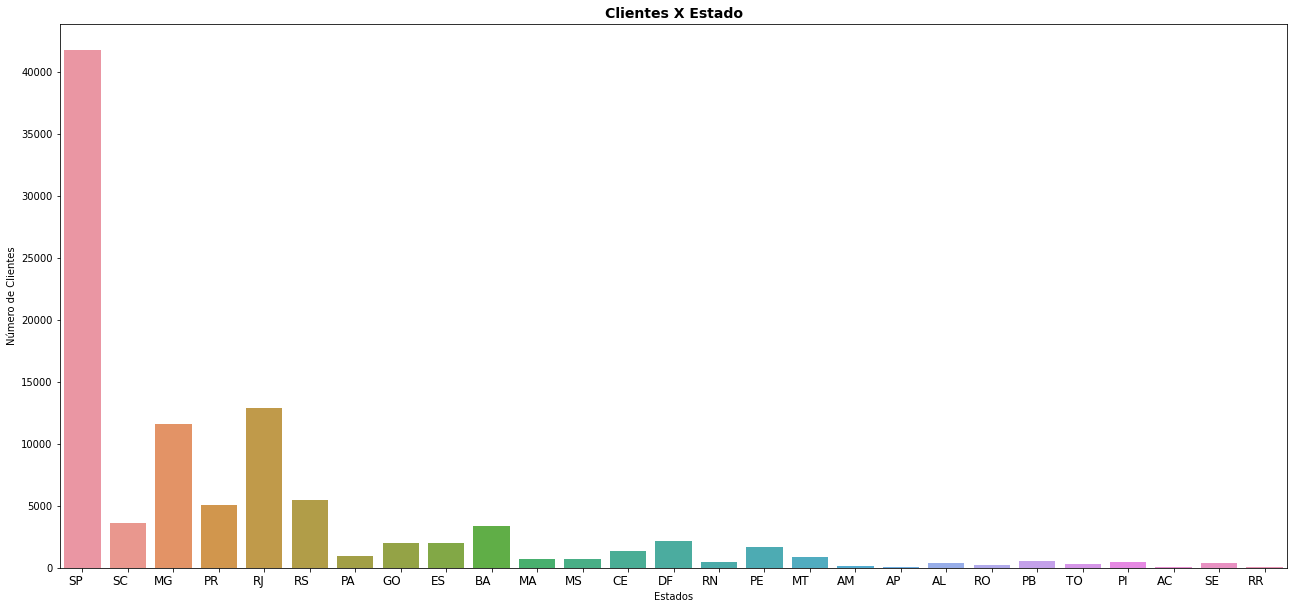

In [13]:
ds_novo_clientes_cluster = ds_novo_clientes_cluster.drop_duplicates()
estados = ds_novo_clientes_cluster['customer_state'].unique()
plt.figure(figsize=(22,10))

ax = sns.countplot(x = 'customer_state',  
                   data = ds_novo_clientes_cluster, 
                   order = estados)

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 0, 
                   ha = 'right', 
                   fontsize = 12)

plt.title('Clientes X Estado', fontsize = 14, fontweight = 'bold')
plt.xlabel('Estados') 
plt.ylabel('Número de Clientes')
plt.show()

In [14]:
ds_novo_clientes_cluster['customer_city'].describe()

count         99441
unique         4119
top       sao paulo
freq          15540
Name: customer_city, dtype: object

In [15]:
ds_novo_clientes_cluster['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

# Análise dos Itens de Pedidos

In [16]:
ds_pedido_itens.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
ds_pedido_itens.shape

(112650, 7)

In [18]:
ds_pedido_itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
ds_pedido_itens.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [20]:
ds_pedido_itens['order_item_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [21]:
ds_pedido_itens['order_item_id'].value_counts()

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64

In [22]:
ds_pedido_itens.tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


In [23]:
ds_pedido_itens.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


### Contar a quantidade de itens por pedido

In [24]:
ds_pedido_itens_grupo = ds_pedido_itens.groupby("order_id").agg({"product_id": "count"})
ds_pedido_itens_grupo.reset_index()

,order_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [25]:
ds_pedido_itens_grupo.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,product_id
order_id,
8272b63d03f5f79c56e9e4120aec44ef,21


### Somar os valores de cada item do pedido

In [26]:
ds_pedidos_itens_preco_somados = ds_pedido_itens.groupby("order_id").agg({"price": "sum"})
ds_pedidos_itens_preco_somados.reset_index()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [27]:
ds_pedidos_itens_preco_somados.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,price
order_id,
8272b63d03f5f79c56e9e4120aec44ef,31.8


### Somar os valores de frete de cada item do pedido. Se o mesmo tipo de produto se repete, soma-se apenas um frete.

In [28]:
ds_pedido_itens.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [29]:
# Retirada da coluna order_item_id
ds_pedido_itens_grupo_frete = ds_pedido_itens
ds_pedido_itens_grupo_frete = ds_pedido_itens_grupo_frete[['order_id', 
                                                           'product_id', 
                                                           'seller_id', 
                                                           'shipping_limit_date', 
                                                           'price', 
                                                           'freight_value']]

# Retira os itens duplicados, para somar o valor real do frete.
ds_pedido_itens_grupo_frete.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [30]:
ds_pedido_itens_grupo_frete = ds_pedido_itens_grupo_frete.groupby("order_id").agg({"freight_value": "sum"})
ds_pedido_itens_grupo_frete.reset_index()

,order_id,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,13.29
1,00018f77f2f0320c557190d7a144bdd3,19.93
2,000229ec398224ef6ca0657da4fc703e,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,36.53
98663,fffce4705a9662cd70adb13d4a31832d,16.95
98664,fffe18544ffabc95dfada21779c9644f,8.72


In [31]:
ds_pedido_itens_grupo_frete.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,freight_value
order_id,
8272b63d03f5f79c56e9e4120aec44ef,164.37


### Juntar os resultados para consolidação de pedidos

In [32]:
# Transformar series em dataframe
ds_pedidos_itens_preco_somados = pd.DataFrame(ds_pedidos_itens_preco_somados, columns=['price'])
ds_pedidos_itens_preco_somados

,price
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.90
00018f77f2f0320c557190d7a144bdd3,239.90
000229ec398224ef6ca0657da4fc703e,199.00
00024acbcdf0a6daa1e931b038114c75,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...
fffc94f6ce00a00581880bf54a75a037,299.99
fffcd46ef2263f404302a634eb57f7eb,350.00
fffce4705a9662cd70adb13d4a31832d,99.90


## Criação da base MASTER para análise de dados.

In [33]:
ds_pedidos_itens_unicos = ds_pedidos_itens_preco_somados.join(ds_pedido_itens_grupo, on="order_id").join(ds_pedido_itens_grupo_frete, on="order_id")
ds_pedidos_itens_unicos.reset_index()
ds_pedidos_itens_unicos.head()

,price,product_id,freight_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,1,13.29
00018f77f2f0320c557190d7a144bdd3,239.90,1,19.93
000229ec398224ef6ca0657da4fc703e,199.00,1,17.87
00024acbcdf0a6daa1e931b038114c75,12.99,1,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,18.14


In [34]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.rename(columns={"product_id": "qt_item", "price": "vl_tot_pedido"})

In [35]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,vl_tot_pedido,qt_item,freight_value
order_id,,,
8272b63d03f5f79c56e9e4120aec44ef,31.8,21,164.37


In [36]:
ds_pedidos_itens_unicos.shape

(98666, 3)

In [37]:
ds_pedidos_itens_unicos.describe()

,vl_tot_pedido,qt_item,freight_value
count,98666.000000,98666.000000,98666.000000
mean,137.754076,1.141731,22.823562
std,210.645145,0.538452,21.650909
min,0.850000,1.000000,0.000000
25%,45.900000,1.000000,13.850000
50%,86.900000,1.000000,17.170000
75%,149.900000,1.000000,24.040000
max,13440.000000,21.000000,1794.960000


In [38]:
ds_pedidos_itens_unicos.head()

,vl_tot_pedido,qt_item,freight_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,1,13.29
00018f77f2f0320c557190d7a144bdd3,239.90,1,19.93
000229ec398224ef6ca0657da4fc703e,199.00,1,17.87
00024acbcdf0a6daa1e931b038114c75,12.99,1,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,18.14


## Análise de frete pago

In [39]:
ds_pedido_frete_pago = ds_pedidos_itens_unicos.query('freight_value != 0.0')
ds_pedido_frete_pago.head()

,vl_tot_pedido,qt_item,freight_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,1,13.29
00018f77f2f0320c557190d7a144bdd3,239.90,1,19.93
000229ec398224ef6ca0657da4fc703e,199.00,1,17.87
00024acbcdf0a6daa1e931b038114c75,12.99,1,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,18.14


In [40]:
ds_pedido_frete_pago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98328 entries, 00010242fe8c5a6d1ba2dd792cb16214 to fffe41c64501cc87c801fd61db3f6244
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vl_tot_pedido  98328 non-null  float64
 1   qt_item        98328 non-null  int64  
 2   freight_value  98328 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 3.0+ MB


In [41]:
ds_pedido_frete_pago.describe()

,vl_tot_pedido,qt_item,freight_value
count,98328.000000,98328.000000,98328.000000
mean,137.844178,1.141770,22.902017
std,210.973502,0.538789,21.646627
min,0.850000,1.000000,5.700000
25%,45.900000,1.000000,13.920000
50%,86.500000,1.000000,17.210000
75%,149.900000,1.000000,24.110000
max,13440.000000,21.000000,1794.960000


## Análise de frete grátis

In [42]:
ds_pedido_frete_gratis = ds_pedidos_itens_unicos.query('freight_value == 0.0')
ds_pedido_frete_gratis.head()

,vl_tot_pedido,qt_item,freight_value
order_id,,,
00404fa7a687c8c44ca69d42695aae73,99.9,1,0.0
00a870c6c06346e85335524935c600c0,69.9,1,0.0
011c899816ea29773525bd3322dbb6aa,99.9,1,0.0
012b3f6ab7776a8ab3443a4ad7bef2e6,107.8,2,0.0
04105b54650921ca3246f52e6f175f46,69.9,1,0.0


In [43]:
ds_pedido_frete_gratis.describe()

,vl_tot_pedido,qt_item,freight_value
count,338.000000,338.000000,338.0
mean,111.542515,1.130178,0.0
std,58.467110,0.429865,0.0
min,53.900000,1.000000,0.0
25%,69.900000,1.000000,0.0
50%,99.900000,1.000000,0.0
75%,112.900000,1.000000,0.0
max,712.900000,5.000000,0.0


## Correlações básicas do frete e quantidade de itens

Para o conjunto de dados em análise de frete grátis, a quantidade de itens têm correlação média com o preço. Isto é, por haver frete grátis, há proporcionalmente mais itens no pedido.

In [44]:
ds_pedido_frete_gratis[['vl_tot_pedido', 'qt_item']].corr()

,vl_tot_pedido,qt_item
vl_tot_pedido,1.000000,0.416931
qt_item,0.416931,1.000000


Já para o conjunto de dados com frete pago, a quantidade de itens tem correlação baixa com o valor do pedido, isto é, o preço do frete pode estar influenciando no valor médio dos pedidos.

A quantidade de itens de pedidos para frete grátis e pago, diferencia em 0,11 do desvio padrão. Isto é, há pouco impacto.

In [45]:
ds_pedido_frete_pago[['vl_tot_pedido', 'qt_item', 'freight_value']].corr()

,vl_tot_pedido,qt_item,freight_value
vl_tot_pedido,1.000000,0.152929,0.413191
qt_item,0.152929,1.000000,0.438178
freight_value,0.413191,0.438178,1.000000


## Análise dos pedidos

In [46]:
ds_pedidos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [47]:
ds_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [48]:
ds_pedidos.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [49]:
ds_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00


### Transformar todas as datas em datetime

In [50]:
ds_pedidos['order_purchase_timestamp']       = pd.to_datetime(ds_pedidos['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_approved_at']              = pd.to_datetime(ds_pedidos['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_delivered_carrier_date']   = pd.to_datetime(ds_pedidos['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_delivered_customer_date']  = pd.to_datetime(ds_pedidos['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_estimated_delivery_date']  = pd.to_datetime(ds_pedidos['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [51]:
ds_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


### Preencher os campos vazios/nulos com dados da média de tempo de aprovação, previsão e entrega do pedido.

### A conclusão desses dados, é baseado em alguns casos analisados pontualmente.

In [52]:
ds_pedidos['order_approved_at'].fillna(value              = (ds_pedidos['order_purchase_timestamp'] + timedelta(minutes=10)), inplace=True)
ds_pedidos['order_delivered_carrier_date'].fillna(value   = (ds_pedidos['order_approved_at'] + timedelta(days=1)), inplace=True)
ds_pedidos['order_delivered_customer_date'].fillna(value  = (ds_pedidos['order_delivered_carrier_date'] + timedelta(days=3)), inplace=True)
ds_pedidos['order_estimated_delivery_date'].fillna(value  = (ds_pedidos['order_delivered_customer_date'] + timedelta(days=4)), inplace=True)

In [53]:
ds_pedidos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [54]:
ds_pedidos.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90893
order_delivered_carrier_date     82792
order_delivered_customer_date    98611
order_estimated_delivery_date      459
dtype: int64

In [55]:
ds_pedidos['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [56]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,vl_tot_pedido,qt_item,freight_value
order_id,,,
8272b63d03f5f79c56e9e4120aec44ef,31.8,21,164.37


In [57]:
ds_pedidos_itens_unicos = ds_pedidos.join(ds_pedidos_itens_unicos, on="order_id")
ds_pedidos_itens_unicos.reset_index()
ds_pedidos_itens_unicos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72


In [58]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37


In [59]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   vl_tot_pedido                  98666 non-null  float64       
 9   qt_item                        98666 non-null  float64       
 10  freight_value                  98666 non-null  float64       
dtypes: datetime64[n

In [60]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
vl_tot_pedido                    775
qt_item                          775
freight_value                    775
dtype: int64

In [61]:
# Inserindo dados de médias aos campos nulos.
ds_pedidos_itens_unicos['vl_tot_pedido'].fillna(value = round(ds_pedidos_itens_unicos['vl_tot_pedido'].mean(), 2), inplace=True)
ds_pedidos_itens_unicos['qt_item'].fillna(value = round(ds_pedidos_itens_unicos['qt_item'].mean(), 0), inplace=True)
ds_pedidos_itens_unicos['freight_value'].fillna(value = round(ds_pedidos_itens_unicos['freight_value'].mean(), 2), inplace=True)

In [62]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
dtype: int64

### Juntando o pedido com o cliente.

In [63]:
ds_novo_clientes_cluster.head()

,customer_id,customer_unique_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP


In [64]:
ds_novo_clientes_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   customer_city       99441 non-null  object
 3   customer_state      99441 non-null  object
dtypes: object(4)
memory usage: 5.8+ MB


In [65]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   vl_tot_pedido                  99441 non-null  float64       
 9   qt_item                        99441 non-null  float64       
 10  freight_value                  99441 non-null  float64       
dtypes: datetime64[n

In [66]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_novo_clientes_cluster, on = "customer_id", how = "left")
ds_pedidos_itens_unicos.reset_index()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_unique_id,customer_city,customer_state
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,af07308b275d755c9edb36a90c618231,barreiras,BA
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,72.00,1.0,13.08,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,SP
99437,99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,174.90,1.0,20.10,da62f9e57a76d978d02ab5362c509660,praia grande,SP
99438,99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,205.99,1.0,65.02,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA
99439,99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,359.98,2.0,81.18,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ


In [67]:
# Pedido usado como base para análise e evolução da base de dados de maneira organizada.
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_unique_id,customer_city,customer_state
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37,4546caea018ad8c692964e3382debd19,sao paulo,SP


In [69]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
dtype: int64

In [70]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.drop(['customer_unique_id'], axis=1)
ds_pedidos_itens_unicos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,santo andre,SP


In [71]:
ds_pedidos_itens_unicos.describe()

,vl_tot_pedido,qt_item,freight_value
count,99441.000000,99441.000000,99441.000000
mean,137.754045,1.140626,22.823534
std,209.822693,0.536495,21.566375
min,0.850000,1.000000,0.000000
25%,45.990000,1.000000,13.900000
50%,88.000000,1.000000,17.270000
75%,149.900000,1.000000,23.920000
max,13440.000000,21.000000,1794.960000


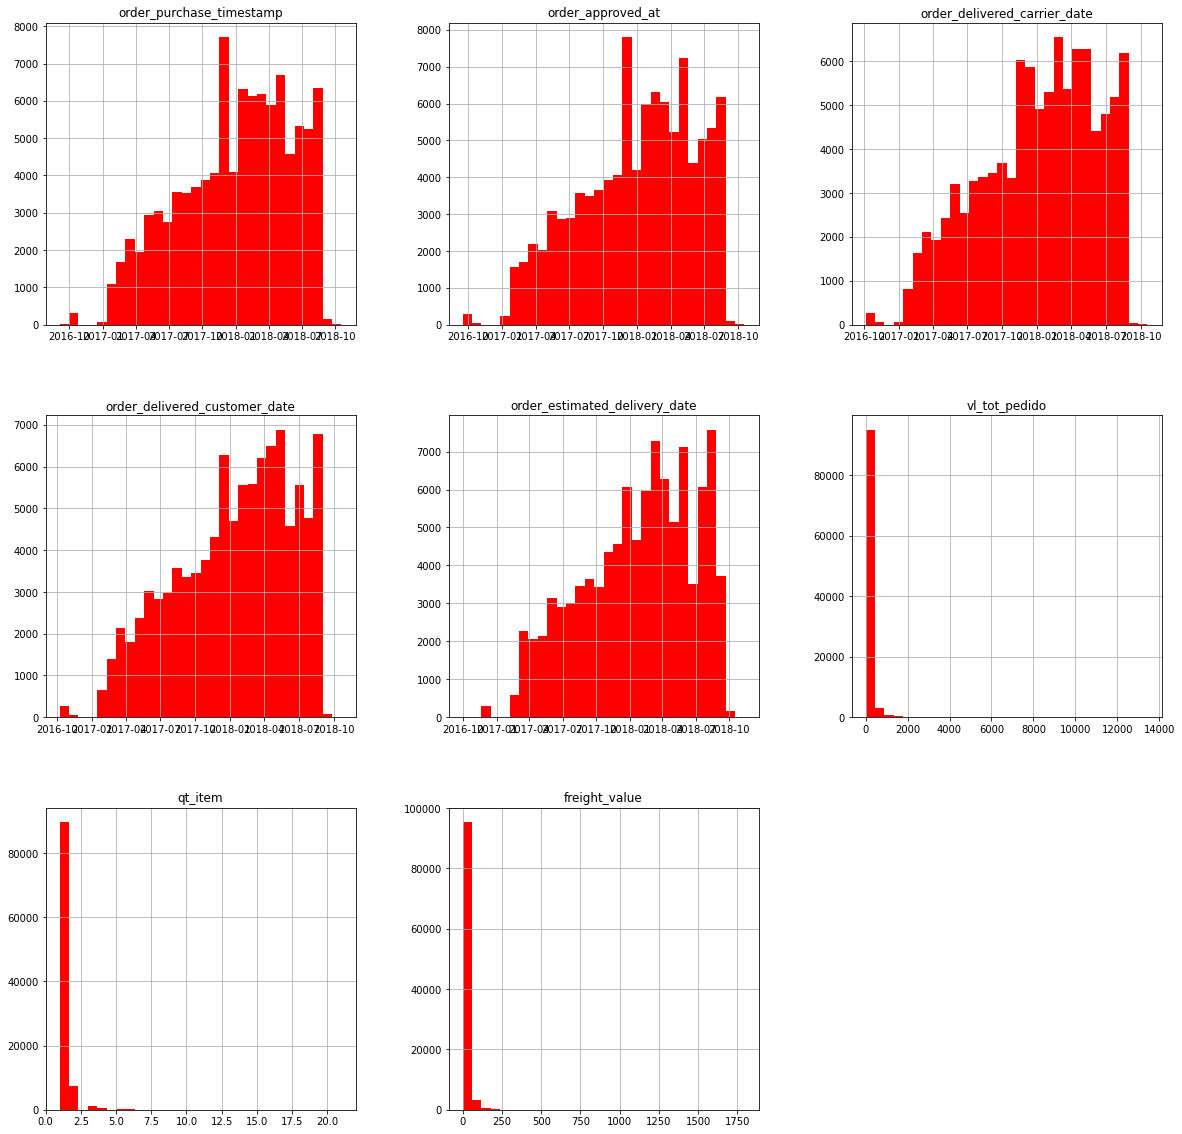

In [72]:
ds_pedidos_itens_unicos.hist(bins = 30, figsize = (20,20), color = 'r');

## Análise boxplot

## Analise dos pedidos com apenas um produto vs pedidos com mais de um produto

In [73]:
pedido_unico_produto = ds_pedidos_itens_unicos.query('qt_item == 1')['qt_item'].count()
tota_pedidos = ds_pedidos_itens_unicos['qt_item'].count()
print('Nº de pedidos com apenas um item: {0}'.format(pedido_unico_produto))
print('\nNº de pedidos com mais de um item: {0}'.format(tota_pedidos - pedido_unico_produto))

Nº de pedidos com apenas um item: 89638

Nº de pedidos com mais de um item: 9803


In [74]:
percentual_pedido_unico_item = (pedido_unico_produto / tota_pedidos) * 100;
percentual_pedido_cliente = (total_clientes_unico / pedido_unico_produto) ;
#print('{0} clientes fazem compras de apenas um único produto por pedido.'.format(total_clientes_unico))
print('% de pedidos com apenas um único produto: {0}%'.format(round(percentual_pedido_unico_item, 2)))
print('\nProporção de pedidos com apenas um único produto por cliente: {0}'.format(round(percentual_pedido_cliente, 2)))
print('\nPodemos concluir que não há compra com item combinado, o percentual é baixo para esta estratégia.')

% de pedidos com apenas um único produto: 90.14%

Proporção de pedidos com apenas um único produto por cliente: 1.07

Podemos concluir que não há compra com item combinado, o percentual é baixo para esta estratégia.


In [75]:
quant_frete_pago = ds_pedido_frete_pago['vl_tot_pedido'].count()
print('Dos {0} pedidos com apenas 1 item, {1}% deles são de fretes pagos, de um total de {2}.'.format(pedido_unico_produto, 
                                                                                                     round((pedido_unico_produto / quant_frete_pago * 100), 2),
                                                                                                    quant_frete_pago))

Dos 89638 pedidos com apenas 1 item, 91.16% deles são de fretes pagos, de um total de 98328.


## Os estados do Norte tem pouca ou nenhuma vendas, enquanto o Sudeste lidera em nº de pedidos

In [76]:
ds_cidade_pedido = ds_pedidos_itens_unicos.groupby('customer_state')['order_id'].count()
ds_cidade_pedido.reset_index()
ds_cidade_pedido.head()

customer_state
AC      81
AL     413
AM     148
AP      68
BA    3380
Name: order_id, dtype: int64

## Estados que geraram mais pedidos

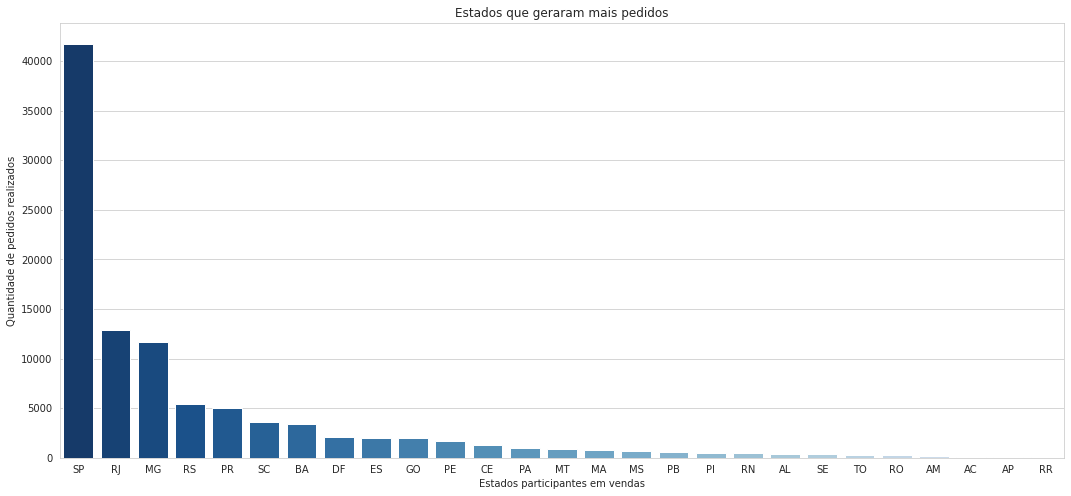

In [78]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("Estados que geraram mais pedidos")

ds_cidade_pedido = ds_cidade_pedido.sort_values(ascending=False)
sns.barplot(x=ds_cidade_pedido.index,
            y=ds_cidade_pedido.values,
            palette=sns.color_palette("Blues_r", n_colors=len(ds_cidade_pedido) + 4)).set(
    xlabel='Estados participantes em vendas',
    ylabel='Quantidade de pedidos realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

In [79]:
ds_cliente_pedido = ds_pedidos_itens_unicos.query('qt_item > 1.0').groupby('customer_state')['order_id'].count()
ds_cliente_pedido.reset_index()
ds_cliente_pedido.head()

customer_state
AC      5
AL     24
AM     10
AP     10
BA    318
Name: order_id, dtype: int64

## Estados que Geraram Pedidos com Mais de um Item

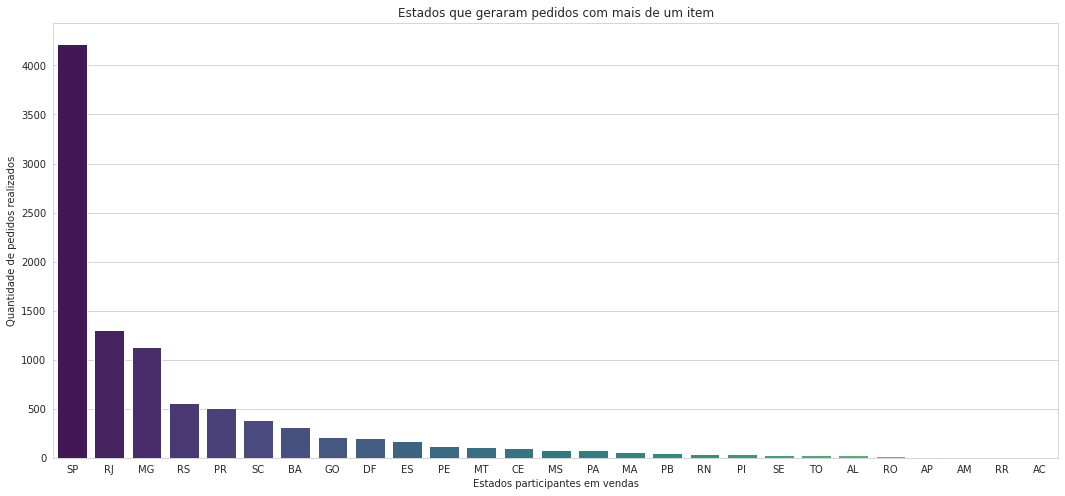

In [80]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("Estados que geraram pedidos com mais de um item")

ds_cliente_pedido = ds_cliente_pedido.sort_values(ascending=False)
sns.barplot(x=ds_cliente_pedido.index,
            y=ds_cliente_pedido.values,
            palette=sns.color_palette("viridis", n_colors=len(ds_cliente_pedido) + 3)).set(
    xlabel='Estados participantes em vendas',
    ylabel='Quantidade de pedidos realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## As 10 cidades com maior valor de vendas

In [81]:
ds_cidade_valor_vendas = ds_pedidos_itens_unicos.groupby(['customer_city'])['vl_tot_pedido'].sum()
ds_cidade_valor_vendas.reset_index()
ds_cidade_valor_vendas.head()

customer_city
abadia dos dourados     358.90
abadiania               949.99
abaete                 1732.81
abaetetuba             4028.57
abaiara                 262.90
Name: vl_tot_pedido, dtype: float64

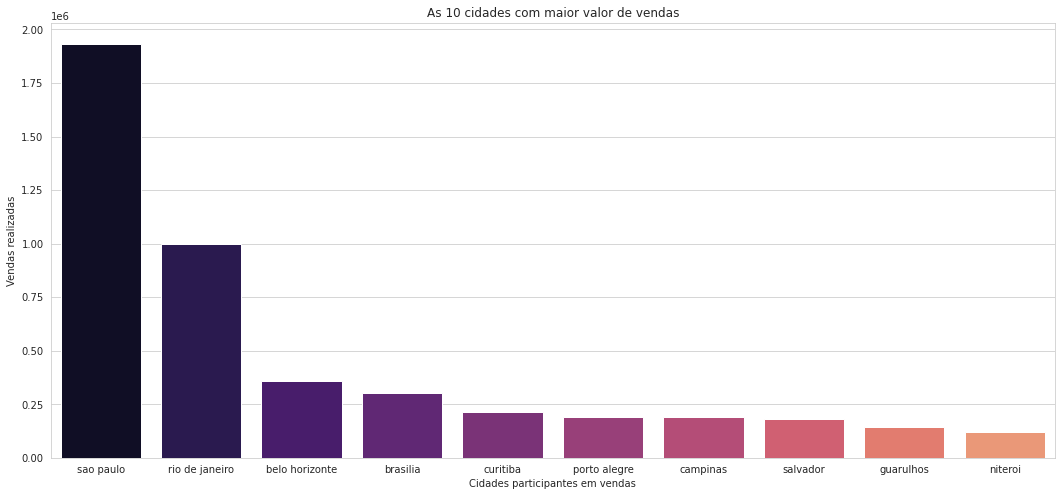

In [82]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("As 10 cidades com maior valor de vendas")

ds_cidade_valor_vendas = ds_cidade_valor_vendas.sort_values(ascending=False)

ds_cidade_valor_vendas = ds_cidade_valor_vendas.iloc[0:10]

sns.barplot(x=ds_cidade_valor_vendas.index,
            y=ds_cidade_valor_vendas.values,
            palette=sns.color_palette("magma", n_colors=len(ds_cidade_valor_vendas) + 2)).set(
    xlabel='Cidades participantes em vendas',
    ylabel='Vendas realizadas'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## As 10 cidades com o maior nº de pedidos

#### A 10ª cidade (São Bernardo do Campo) com o maior nº de pedidos não é a cidade com o maior valor em vendas, nesta amostra, a 10ª posição é de Niterói.

In [83]:
ds_cidade_pedidos = ds_pedidos_itens_unicos.groupby(['customer_city'])['order_id'].count()
ds_cidade_pedidos.reset_index()
ds_cidade_pedidos.head()

customer_city
abadia dos dourados     3
abadiania               1
abaete                 12
abaetetuba             11
abaiara                 2
Name: order_id, dtype: int64

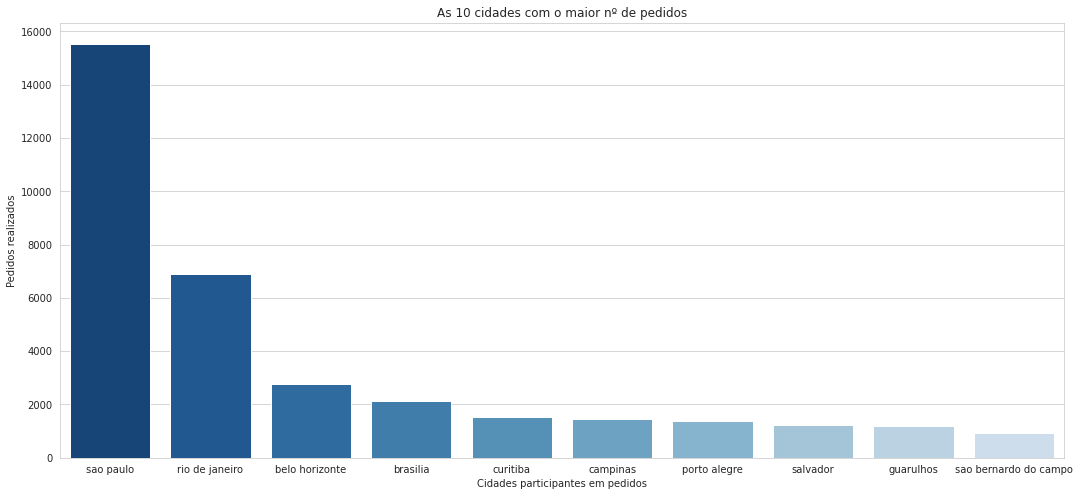

In [84]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("As 10 cidades com o maior nº de pedidos")

ds_cidade_pedidos = ds_cidade_pedidos.sort_values(ascending=False)

ds_cidade_pedidos = ds_cidade_pedidos.iloc[0:10]

sns.barplot(x=ds_cidade_pedidos.index,
            y=ds_cidade_pedidos.values,
            palette=sns.color_palette("Blues_r", n_colors=len(ds_cidade_pedidos) + 2)).set(
    xlabel='Cidades participantes em pedidos',
    ylabel='Pedidos realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## Os 10 estados com maior valor em vendas

In [85]:
ds_estado_vendas = ds_pedidos_itens_unicos.groupby('customer_state')['vl_tot_pedido'].sum()
ds_estado_vendas.reset_index()
ds_estado_vendas.head()

customer_state
AC     15982.95
AL     80590.31
AM     22494.59
AP     13474.30
BA    514380.49
Name: vl_tot_pedido, dtype: float64

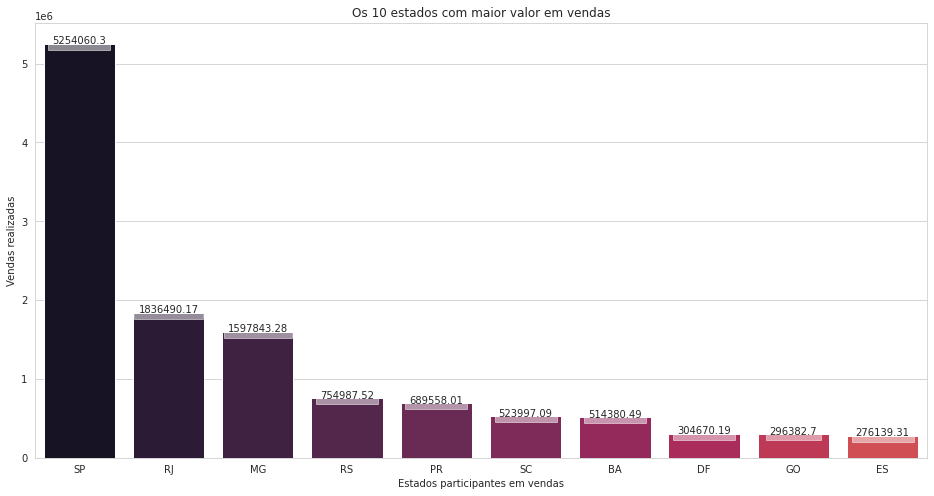

In [86]:
sns.set_style("whitegrid")

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
            bbox = dict(facecolor = 'white', alpha = .5))

plt.figure(figsize=(16,8))
plt.title("Os 10 estados com maior valor em vendas")

ds_estado_vendas = ds_estado_vendas.sort_values(ascending=False)

ds_estado_vendas = ds_estado_vendas.iloc[0:10]

sns.barplot(x=ds_estado_vendas.index,
            y=ds_estado_vendas.values,
            palette=sns.color_palette("rocket", n_colors=len(ds_estado_vendas) + 6)).set(
    xlabel='Estados participantes em vendas',
    ylabel='Vendas realizadas'
)

addlabels(ds_estado_vendas.index, ds_estado_vendas.values)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

In [87]:
ds_estado_status_logistica = ds_pedidos_itens_unicos.groupby('order_status')['customer_state'].count()
ds_estado_status_logistica.reset_index()
ds_estado_status_logistica = ds_estado_status_logistica.sort_values(ascending=False)
ds_estado_status_logistica.head()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
Name: customer_state, dtype: int64

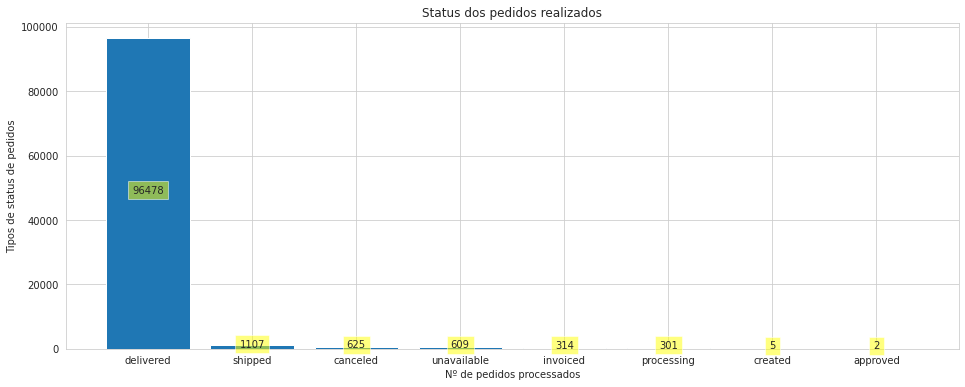

In [88]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',
            bbox = dict(facecolor = 'yellow', alpha = .5))
  
if __name__ == '__main__':

    x = ds_estado_status_logistica.index
    y = ds_estado_status_logistica.values

    plt.figure(figsize = (16,6))

    plt.bar(x, y)

    addlabels(x, y)
    
    plt.title("Status dos pedidos realizados")
    plt.xlabel('Nº de pedidos processados')
    plt.ylabel('Tipos de status de pedidos')
    plt.show()

In [89]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37,sao paulo,SP


In [90]:
ds_produtos_pedidos = ds_pedidos_itens_unicos[['order_id', 'customer_city', 'customer_state']]
ds_produtos_pedidos.head()

,order_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP


In [91]:
ds_pedido_itens

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [92]:
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_pedido_itens, on = "order_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
101222,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101223,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101224,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101225,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101226,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101227,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,6.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101228,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,7.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101229,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,8.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101230,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,9.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101231,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,10.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [ ]:
ds_produtos_pedidos.columns

Index(['order_id', 'customer_city', 'customer_state', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value'],
      dtype='object')

In [93]:
ds_produtos_categoria = ds_produtos[['product_id', 'product_category_name']]
ds_produtos_categoria.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [94]:
ds_pedido_status = ds_pedidos_itens_unicos[['order_id','order_status']]
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_produtos_categoria, on = "product_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_pedido_status, on = "order_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos.head()

,order_id,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,delivered


In [95]:
ds_produtos_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               113425 non-null  object 
 1   customer_city          113425 non-null  object 
 2   customer_state         113425 non-null  object 
 3   order_item_id          112650 non-null  float64
 4   product_id             112650 non-null  object 
 5   seller_id              112650 non-null  object 
 6   shipping_limit_date    112650 non-null  object 
 7   price                  112650 non-null  float64
 8   freight_value          112650 non-null  float64
 9   product_category_name  111047 non-null  object 
 10  order_status           113425 non-null  object 
dtypes: float64(3), object(8)
memory usage: 10.4+ MB


In [96]:
ds_produtos_pedidos.isnull().sum()

order_id                    0
customer_city               0
customer_state              0
order_item_id             775
product_id                775
seller_id                 775
shipping_limit_date       775
price                     775
freight_value             775
product_category_name    2378
order_status                0
dtype: int64

In [97]:
ds_produtos_pedidos = ds_produtos_pedidos.dropna()
ds_produtos_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111047 entries, 0 to 113424
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               111047 non-null  object 
 1   customer_city          111047 non-null  object 
 2   customer_state         111047 non-null  object 
 3   order_item_id          111047 non-null  float64
 4   product_id             111047 non-null  object 
 5   seller_id              111047 non-null  object 
 6   shipping_limit_date    111047 non-null  object 
 7   price                  111047 non-null  float64
 8   freight_value          111047 non-null  float64
 9   product_category_name  111047 non-null  object 
 10  order_status           111047 non-null  object 
dtypes: float64(3), object(8)
memory usage: 10.2+ MB


In [98]:
ds_produtos_pedidos.head()

,order_id,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,delivered


In [99]:
ds_produtos_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_status
101222,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101223,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101224,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101225,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101226,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101227,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,6.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101228,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,7.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101229,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,8.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101230,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,9.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered
101231,8272b63d03f5f79c56e9e4120aec44ef,sao paulo,SP,10.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,beleza_saude,delivered


## Os 15 vendedores com mais vendas realizadas

In [100]:
ds_vendedor_pedido = ds_produtos_pedidos[['seller_id', 'order_id', 'price', 'product_category_name', 'order_status']]

ds_vendedor_pedido = ds_vendedores[['seller_id', 'seller_city', 'seller_state']].merge(ds_vendedor_pedido, on = "seller_id", how = "left")

ds_vendedor_pedido.reset_index()

ds_vendedor_pedido = ds_vendedor_pedido.dropna()


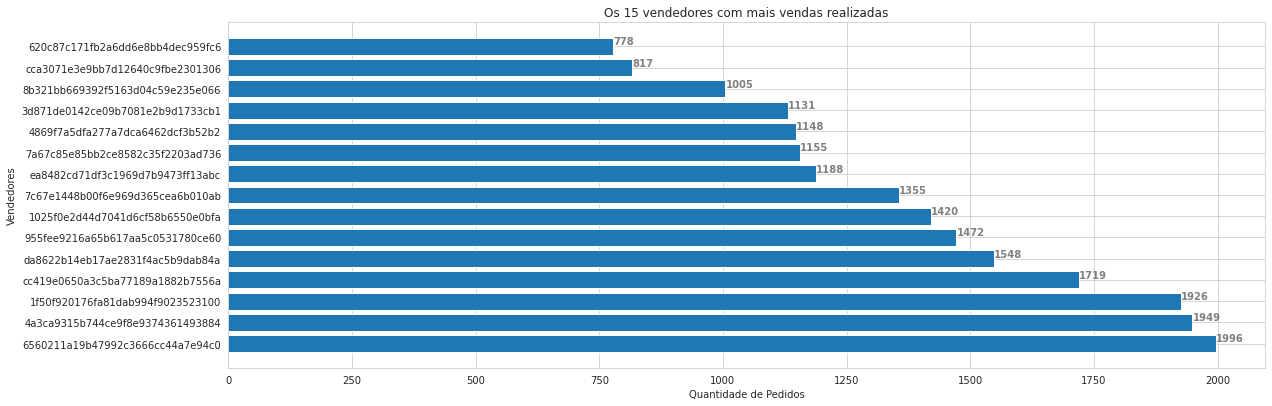

In [102]:
ds_vendedor_pedido_melhores = ds_vendedor_pedido.query('order_status == "delivered"').groupby('seller_id')['order_id'].count()

ds_vendedor_pedido_melhores.reset_index()

ds_vendedor_pedido_melhores = ds_vendedor_pedido_melhores.sort_values(ascending=False)

ds_vendedor_pedido_melhores = ds_vendedor_pedido_melhores.iloc[0:15]

fig= plt.figure(figsize=(18,6))

axes= fig.add_axes([0.1,0.1,0.8,0.8])

plt.title("Os 15 vendedores com mais vendas realizadas")
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Vendedores')
axes.barh(ds_vendedor_pedido_melhores.index, ds_vendedor_pedido_melhores.values, align='center', alpha=1.0)

for i in axes.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()

## Os 15 maiores vendedores e o valor médio de vendas

In [103]:
ds_media_valores_vendedor_pedido = ds_vendedor_pedido[['seller_id', 'price', 'product_category_name']]

ds_vendedor_pedido_melhores = pd.DataFrame(ds_vendedor_pedido_melhores)

ds_media_valores_vendedor_pedido = ds_media_valores_vendedor_pedido.merge(ds_vendedor_pedido_melhores, on = "seller_id", how = "left")

ds_media_valores_vendedor_pedido.reset_index()

ds_media_valores_vendedor_pedido = ds_media_valores_vendedor_pedido.dropna()

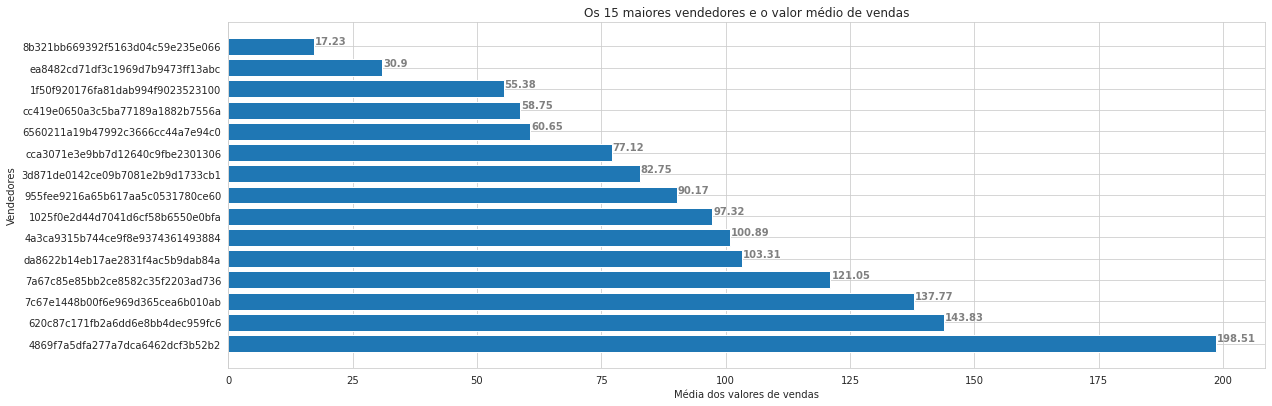

In [104]:
ds_media_valores_vendedor = ds_media_valores_vendedor_pedido.groupby('seller_id')['price'].mean()

ds_media_valores_vendedor.reset_index()

ds_media_valores_vendedor = ds_media_valores_vendedor.sort_values(ascending=False)

fig= plt.figure(figsize=(18,6))

axes= fig.add_axes([0.1,0.1,0.8,0.8])

plt.title("Os 15 maiores vendedores e o valor médio de vendas")
plt.xlabel('Média dos valores de vendas')
plt.ylabel('Vendedores')
axes.barh(ds_media_valores_vendedor.index, ds_media_valores_vendedor.values, align='center', alpha=1.0)

for i in axes.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
plt.show()

## As 15 categorias mais vendidas pelos melhores vendedores

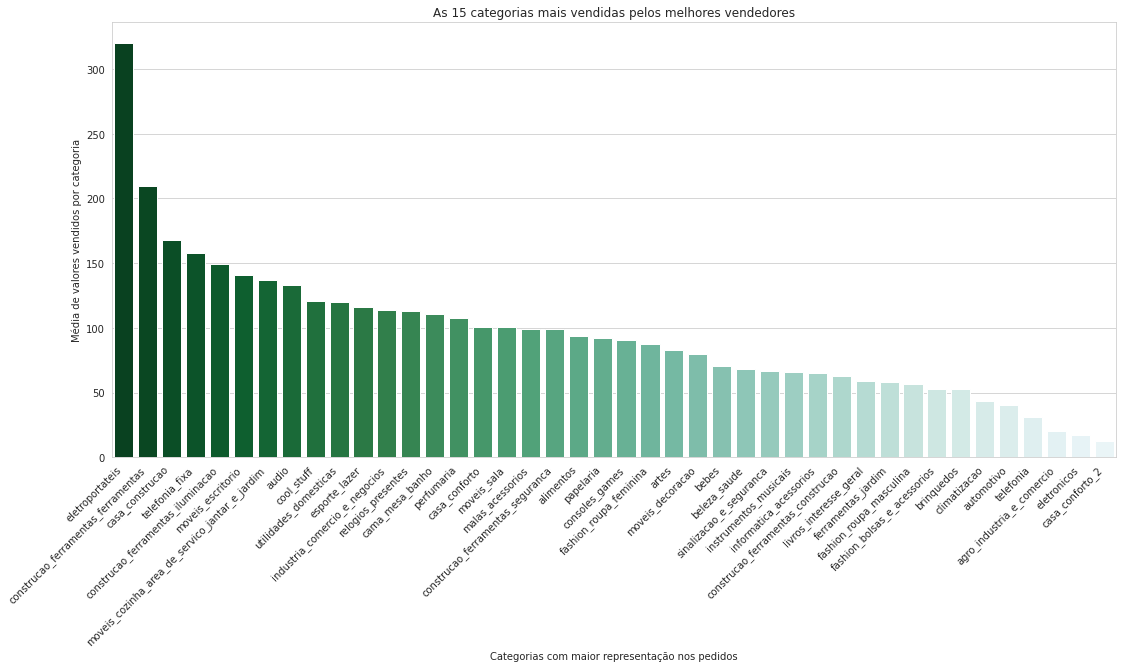

In [105]:
ds_media_valores_categoria = ds_media_valores_vendedor_pedido.groupby('product_category_name')['price'].mean()

ds_media_valores_categoria.reset_index()

ds_media_valores_categoria = ds_media_valores_categoria.sort_values(ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(18,8))

sns.barplot(x=ds_media_valores_categoria.index,
            y=ds_media_valores_categoria.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(ds_media_valores_categoria) + 4))
locs, labels = plt.xticks()
plt.title("As 15 categorias mais vendidas pelos melhores vendedores")
plt.xlabel('Categorias com maior representação nos pedidos')
plt.ylabel('Média de valores vendidos por categoria')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

## Categorias mais vendidas

In [106]:
ds_produtos_categorias_vendidos = ds_produtos_pedidos.groupby('product_category_name')['product_id'].count()

ds_produtos_categorias_vendidos.reset_index()

ds_produtos_categorias_vendidos.head()

product_category_name
agro_industria_e_comercio    212
alimentos                    510
alimentos_bebidas            278
artes                        209
artes_e_artesanato            24
Name: product_id, dtype: int64

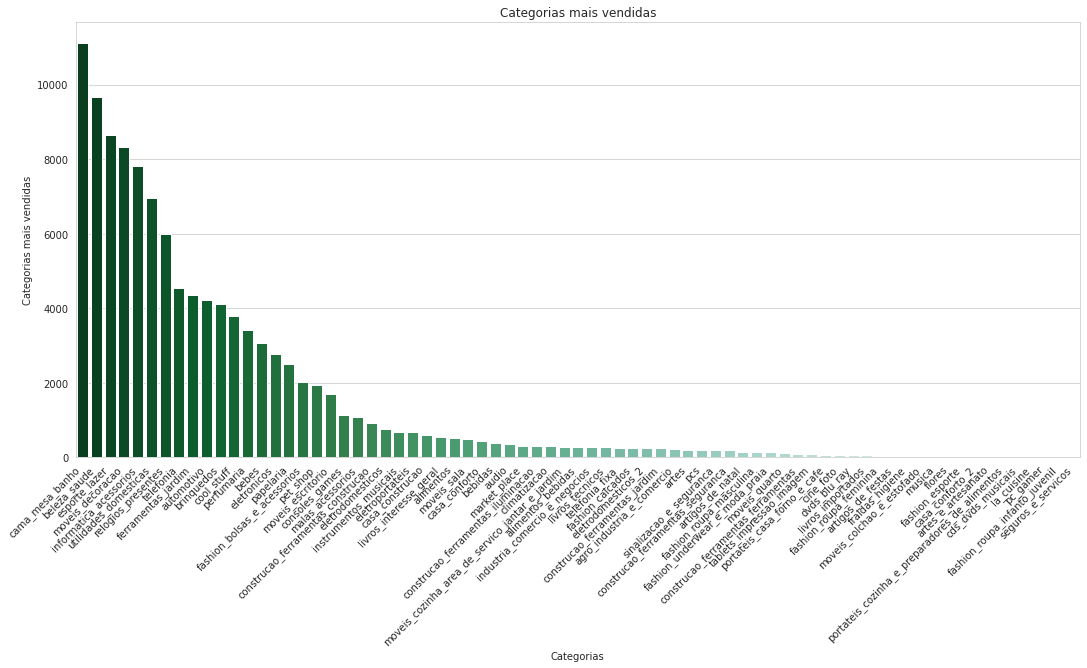

In [108]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

ds_produtos_categorias_vendidos = ds_produtos_categorias_vendidos.sort_values(ascending=False)

sns.barplot(x=ds_produtos_categorias_vendidos.index,
            y=ds_produtos_categorias_vendidos.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(ds_produtos_categorias_vendidos) + 4))
locs, labels = plt.xticks()
plt.title("Categorias mais vendidas")
plt.xlabel('Categorias')
plt.ylabel('Categorias mais vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

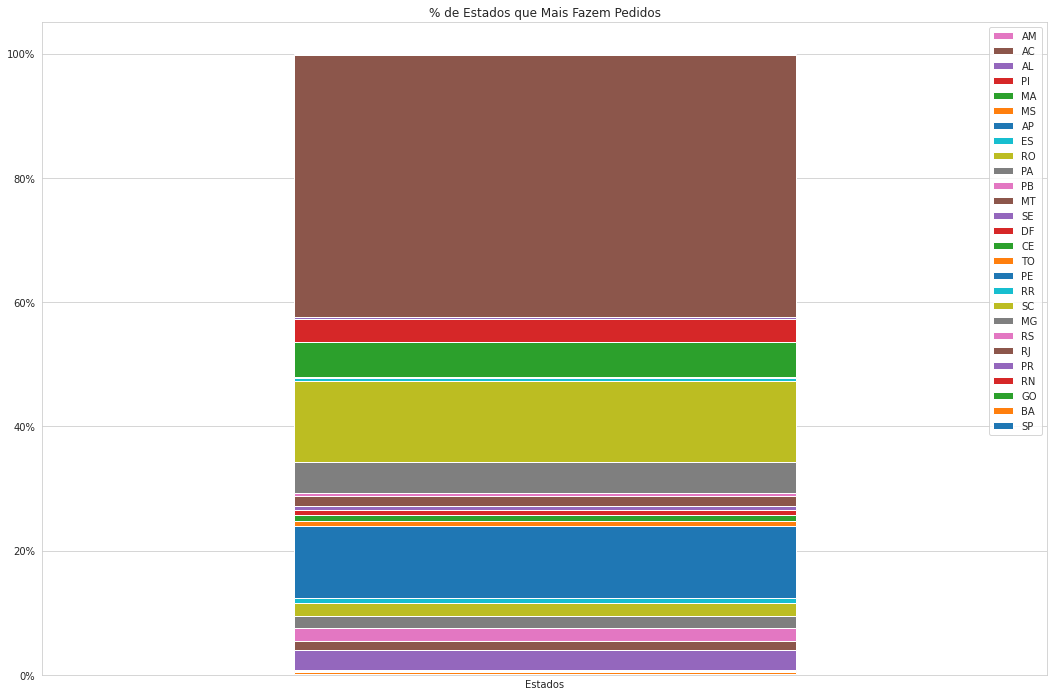

In [109]:
ds_produtos_pedidos.assign(dummy = 1).groupby(['dummy','customer_state']
).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
).to_frame().unstack().plot(kind='bar', stacked = True, legend = False, figsize = (18, 12), layout = (3,4))


plt.title('% de Estados que Mais Fazem Pedidos')
plt.xlabel('Estados')

plt.xticks([])

current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
correct_labels = reversed(ds_produtos_pedidos['customer_state'].unique())

plt.legend(reversed_handles,correct_labels)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [110]:
ds_vendedor_pedido.head()

,seller_id,seller_city,seller_state,order_id,price,product_category_name,order_status
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,6d953888a914b67350d5bc4d48f2acab,101.7,esporte_lazer,delivered
1,3442f8959a84dea7ee197c632cb2df15,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,10.8,esporte_lazer,delivered
2,3442f8959a84dea7ee197c632cb2df15,campinas,SP,4a90af3e85dd563884e2afeab1091394,106.2,esporte_lazer,delivered
3,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,1887b26eba419ce20f6fe34a6f88e80a,209.9,malas_acessorios,delivered
4,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,83f24bbc4f76a2730ba9c9cfa32e6d07,209.9,malas_acessorios,delivered


In [111]:
ds_vendedor_pedido_temp = ds_vendedor_pedido[['seller_id', 'seller_city', 'seller_state', 'order_id']].drop_duplicates()

In [112]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_vendedor_pedido_temp[['seller_id', 'seller_city', 'seller_state', 'order_id']], on='order_id')

ds_pedidos_itens_unicos.reset_index()

ds_pedidos_itens_unicos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,barreiras,BA,289cdb325fb7e7f891c38608bf9e0962,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,vianopolis,GO,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,sao goncalo do amarante,RN,66922902710d126a0e7d26b0e3805106,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,santo andre,SP,2c9e548be18521d1c43cde1c582c6de8,mogi das cruzes,SP


In [113]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state
88089,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37,sao paulo,SP,2709af9587499e95e803a6498a5a56e9,sao paulo,SP


In [114]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98592 entries, 0 to 98591
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98592 non-null  object        
 1   customer_id                    98592 non-null  object        
 2   order_status                   98592 non-null  object        
 3   order_purchase_timestamp       98592 non-null  datetime64[ns]
 4   order_approved_at              98592 non-null  datetime64[ns]
 5   order_delivered_carrier_date   98592 non-null  datetime64[ns]
 6   order_delivered_customer_date  98592 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98592 non-null  datetime64[ns]
 8   vl_tot_pedido                  98592 non-null  float64       
 9   qt_item                        98592 non-null  float64       
 10  freight_value                  98592 non-null  float64       
 11  customer_city  

In [115]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
customer_city                    0
customer_state                   0
seller_id                        0
seller_city                      0
seller_state                     0
dtype: int64

### Alteração do formato de datas

In [116]:
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['ano_venda'].apply(lambda x: x.year)
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['ano_venda'].astype(int)

In [117]:
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['mes_venda'].apply(lambda x: x.month)
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['mes_venda'].astype(int)

In [118]:
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['dia_venda'].apply(lambda x: x.day)
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['dia_venda'].astype(int)

In [119]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state,ano_venda,mes_venda,dia_venda
88089,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37,sao paulo,SP,2709af9587499e95e803a6498a5a56e9,sao paulo,SP,2017,7,16


## Comportamento das entregas realizadas

In [120]:
pd.set_option('mode.chained_assignment', None)
ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos.query('order_status == "delivered"')

ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_without_hours'] = ds_pedidos_itens_unicos_delivered['order_delivered_customer_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

ds_pedidos_itens_unicos_delivered_antes = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours < order_estimated_delivery_date')
ds_pedidos_itens_unicos_delivered_depois = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours > order_estimated_delivery_date')
ds_pedidos_itens_unicos_delivered_dia = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours == order_estimated_delivery_date')

In [121]:
total_entregas = ds_pedidos_itens_unicos_delivered['order_id'].count()

percentual_entrega_antes = (ds_pedidos_itens_unicos_delivered_antes['order_id'].count() / total_entregas) * 100
percentual_entrega_depois = (ds_pedidos_itens_unicos_delivered_depois['order_id'].count() / total_entregas) * 100
percentual_entrega_dia = (ds_pedidos_itens_unicos_delivered_dia['order_id'].count() / total_entregas) * 100

print('De acordo com a amostra de dados, temos {0} entregas realizadas.'.format(total_entregas))
print('\nDe todas as entregas, {0}% delas foram realizadas antes da estimativa prevista.'.format(round(percentual_entrega_antes, 2)))
print('\nEnquanto que {0}% delas foram realizadas na data prevista.'.format(round(percentual_entrega_dia, 2)))
print('\nPor fim, tivemos apenas {0}% de entregas fora do prazo previsto.'.format(round(percentual_entrega_depois, 2)))


De acordo com a amostra de dados, temos 96458 entregas realizadas.

De todas as entregas, 91.99% delas foram realizadas antes da estimativa prevista.

Enquanto que 1.32% delas foram realizadas na data prevista.

Por fim, tivemos apenas 6.69% de entregas fora do prazo previsto.


In [122]:
ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'] = ds_pedidos_itens_unicos_delivered['order_delivered_customer_date'].apply(lambda x: x.strftime('%H:%M:%S'))

ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos_delivered.sort_values(by = ['order_delivered_customer_date_with_hours'], ascending=False)

ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'] = pd.to_datetime(ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'], format='%H:%M:%S')

ds_pedidos_itens_unicos_delivered_2016 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2016')
ds_pedidos_itens_unicos_delivered_2017 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2017')
ds_pedidos_itens_unicos_delivered_2018 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2018')

## Hora das Entregas no Ano de 2016 por Estado

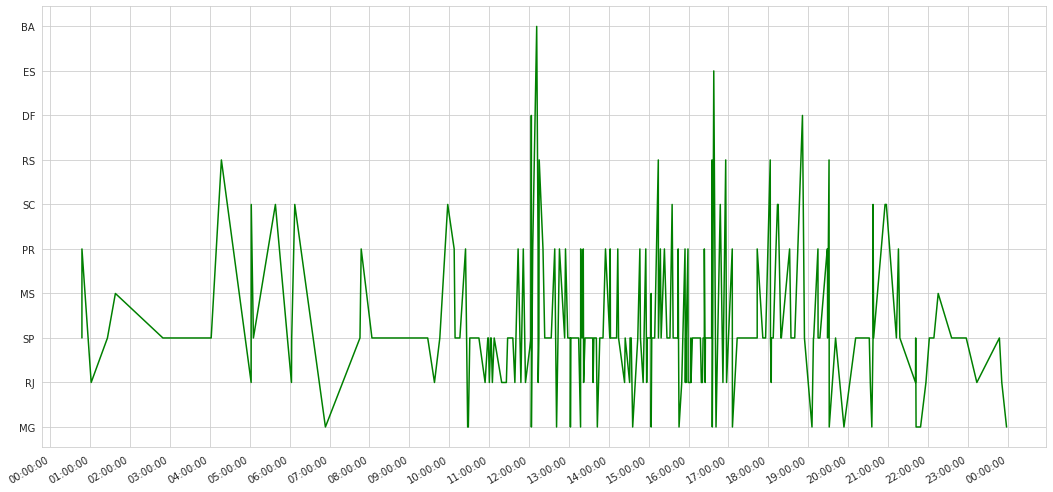

In [123]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2016, color = 'g')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2016['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2016['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Hora das Entregas no Ano de 2018 por Estado

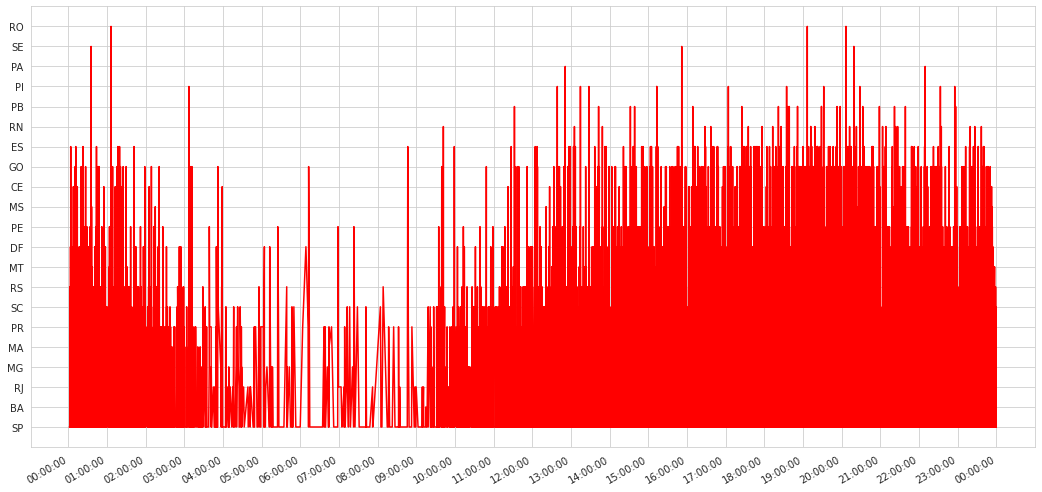

In [124]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2018, color = 'r')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2018['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2018['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Hora das Entregas no Ano de 2017 por Estado

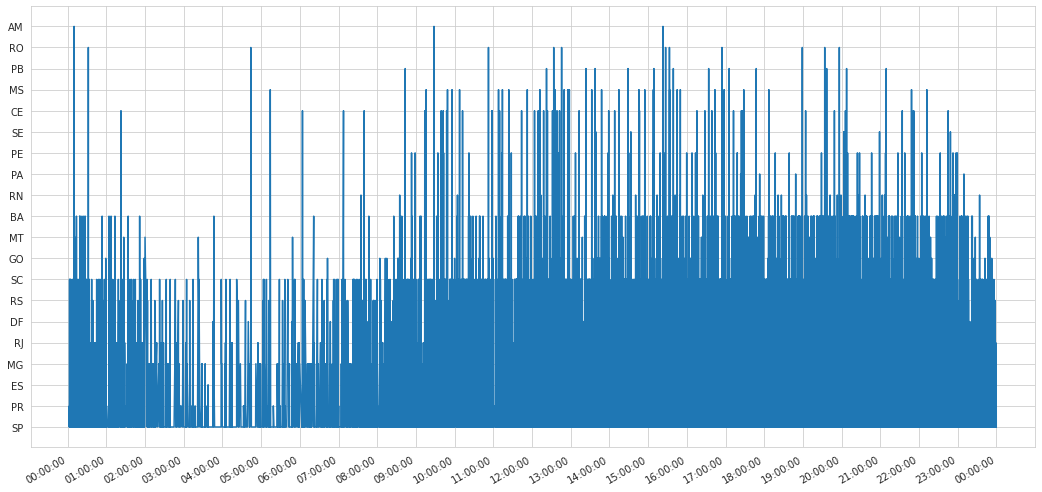

In [125]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2017)
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2017['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2017['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

# Horário de Compras por Estado

In [126]:
ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'] = ds_pedidos_itens_unicos_delivered['order_purchase_timestamp'].apply(lambda x: x.strftime('%H:%M:%S'))

ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos_delivered.sort_values(by = ['order_purchase_timestamp_with_hours'], ascending=False)

ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'] = pd.to_datetime(ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'], format='%H:%M:%S')

ds_pedidos_itens_unicos_delivered_2016 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2016')
ds_pedidos_itens_unicos_delivered_2017 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2017')
ds_pedidos_itens_unicos_delivered_2018 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2018')

## Compras 2016

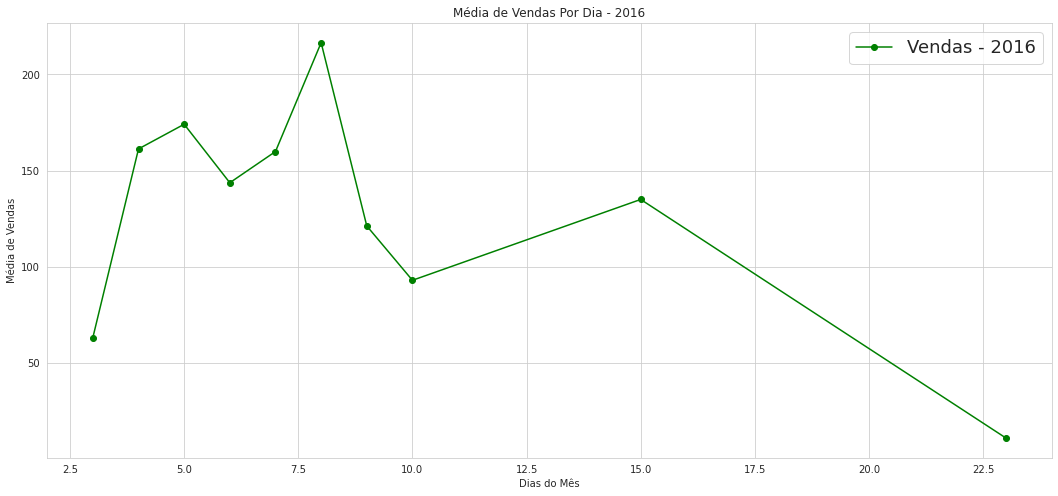

In [127]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2016.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,8))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2016", marker='o', color='g')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2016')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

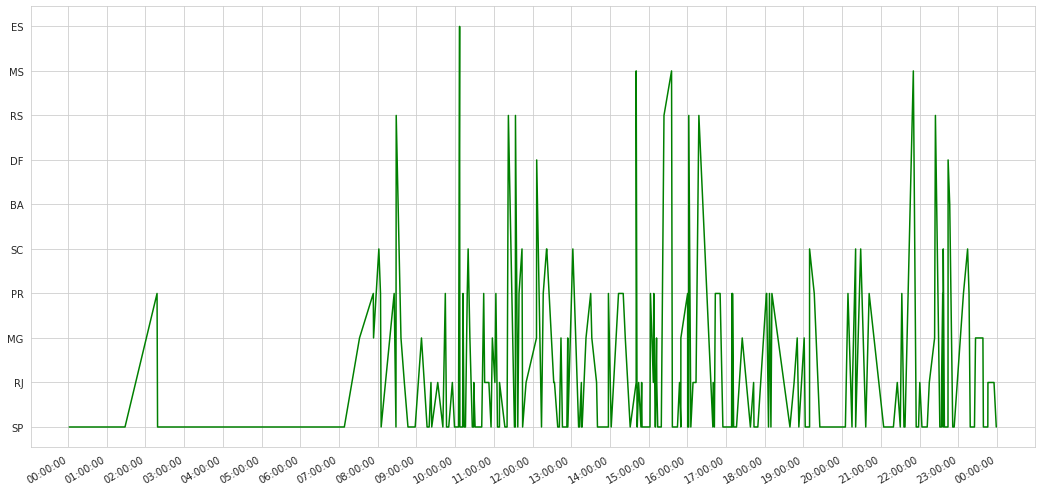

In [128]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2016, color = 'g')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2016['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2016['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Compras 2017

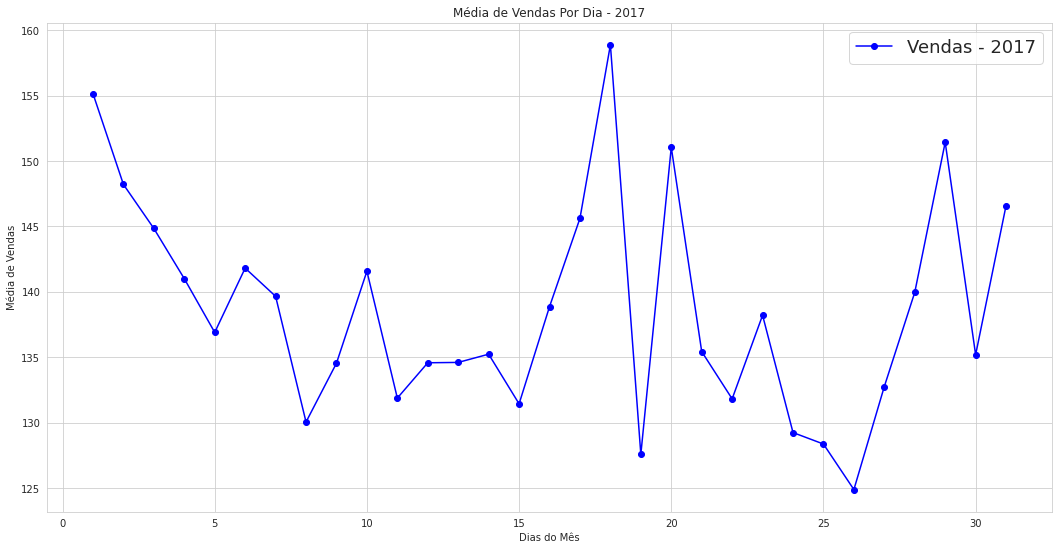

In [130]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2017.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,9))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2017", marker='o', color='b')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2017')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

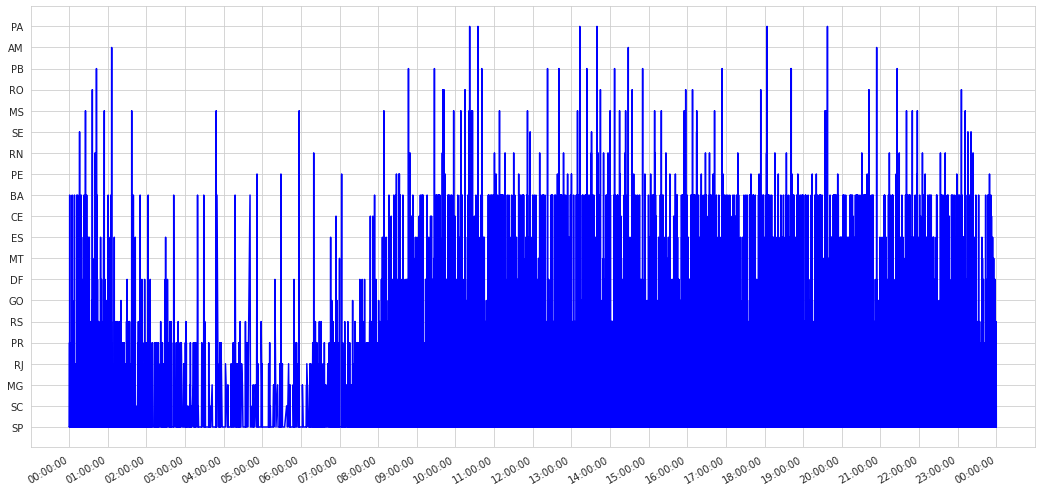

In [131]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2017, color = 'b')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2017['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2017['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show() 

## Compras 2018

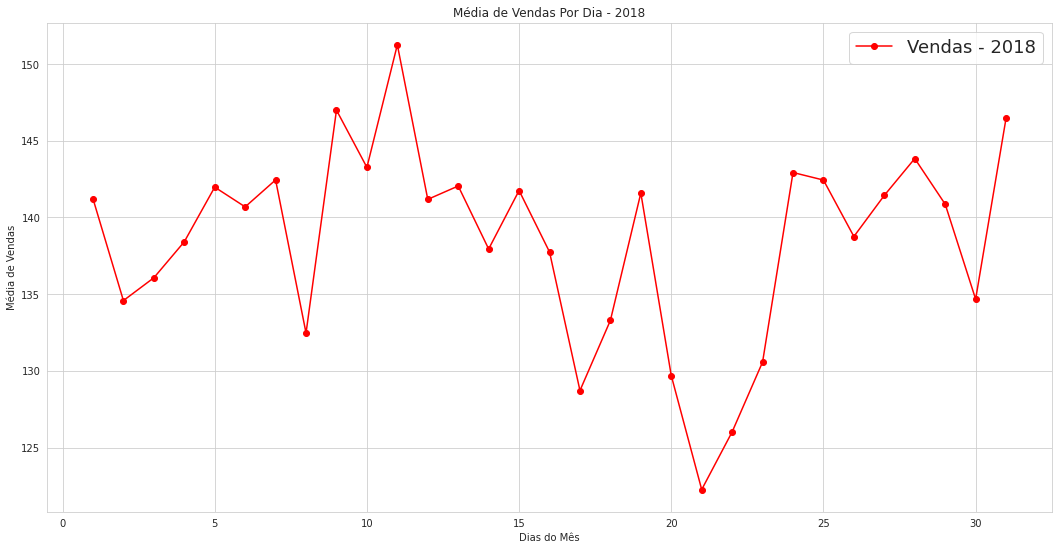

In [132]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2018.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,9))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2018", marker='o', color='r')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2018')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

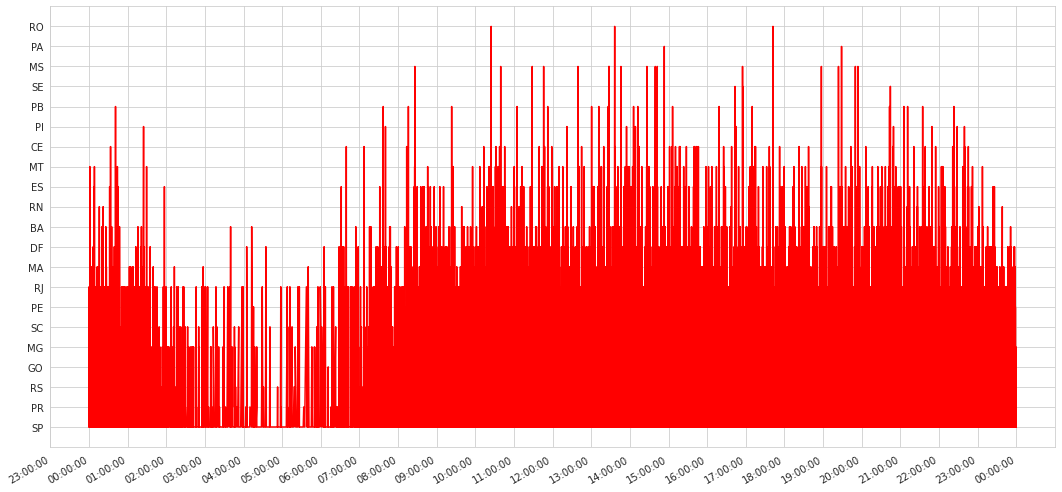

In [133]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2018, color = 'r')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2018['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2018['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show() 

## Vendas e Fretes por Ano

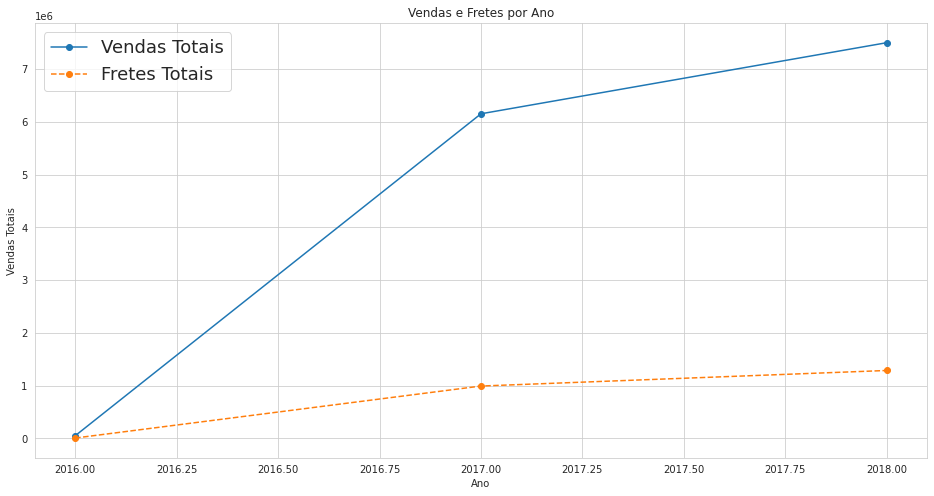

In [134]:
ds_ano_vendas_total = ds_pedidos_itens_unicos.groupby('ano_venda')['vl_tot_pedido'].sum()
ds_ano_vendas_total.reset_index()

ds_ano_frete_total = ds_pedidos_itens_unicos.groupby('ano_venda')['freight_value'].sum()
ds_ano_frete_total.reset_index()

plt.figure(figsize=(16,8))
plt.plot(ds_ano_vendas_total.index, ds_ano_vendas_total.values, label = "Vendas Totais", marker='o')
plt.plot(ds_ano_frete_total.index, ds_ano_frete_total.values, label = "Fretes Totais", linestyle="--", marker='o')
plt.legend(fontsize=18)
plt.title('Vendas e Fretes por Ano')
plt.xlabel('Ano')
plt.ylabel('Vendas Totais')
plt.show()

## Vendas e Fretes por Mês - Acumulado

#### Pelo gráfico podemos concluir que as maiores vendas ocorrem no meio do ano, entre Março e Setembro.
#### O crescimento nas vendas começa ocorrer após o evento do carnaval.

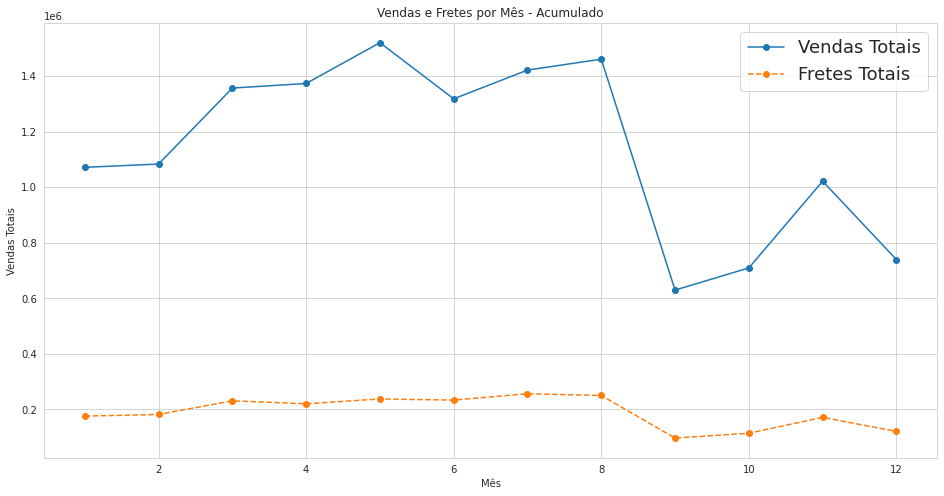

In [135]:
ds_mes_vendas_total = ds_pedidos_itens_unicos.groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_vendas_total.reset_index()

ds_mes_frete_total = ds_pedidos_itens_unicos.groupby('mes_venda')['freight_value'].sum()
ds_mes_frete_total.reset_index()

plt.figure(figsize=(16,8))
plt.plot(ds_mes_vendas_total.index, ds_mes_vendas_total.values, label = "Vendas Totais", marker='o')
plt.plot(ds_mes_frete_total.index, ds_mes_frete_total.values, label = "Fretes Totais", linestyle="--", marker='o')
plt.legend(fontsize=18)
plt.title('Vendas e Fretes por Mês - Acumulado')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
plt.show()

## Vendas, Fretes e Clientes por Mês/Ano

#### Os gráficos abaixo são semelhantes, isto mostra que o crescimento nas vendas é também um crescimento de novos clientes, já que clientes vs pedidos são de 1:1. 

#### Portanto, podemos concluir que o LTV, de acordo com esta amostra, é alto, ocasionando maior investimento na aquisição de clientes. 

#### A Recorrência de clientes em voltar a comprar produtos é muito baixa.

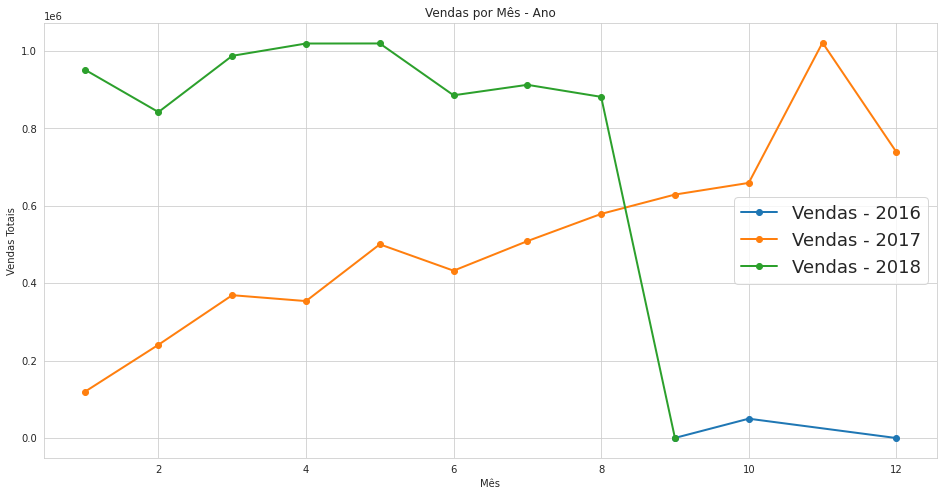

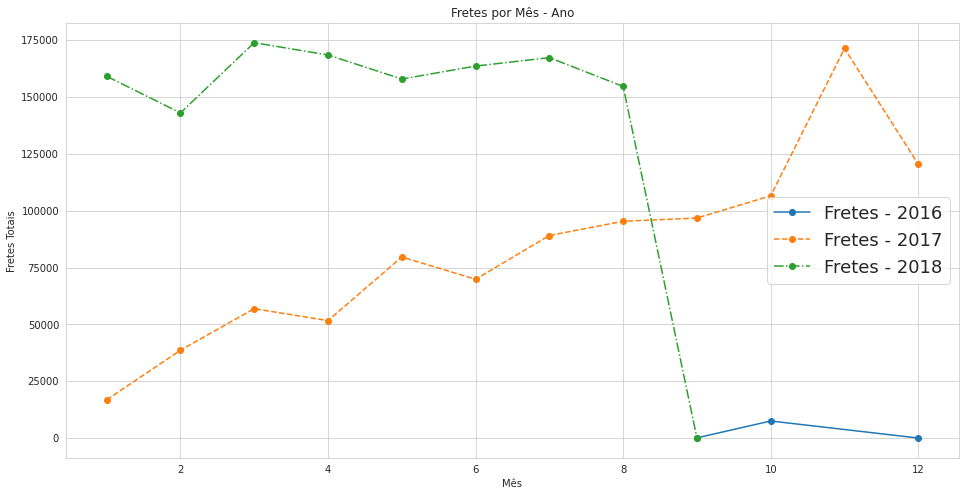

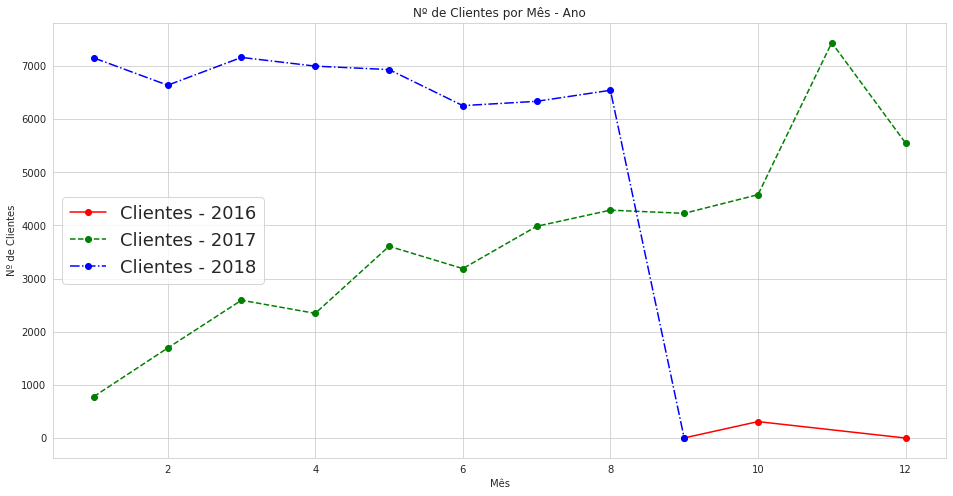

In [136]:
# Vendas, frete e cliente mês a mês de cada ano
ds_mes_ano_vendas_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_ano_vendas_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_ano_vendas_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['vl_tot_pedido'].sum()

plt.figure(figsize=(16,8))

# Vendas
plt.plot(ds_mes_ano_vendas_total_01.index, ds_mes_ano_vendas_total_01.values, label = "Vendas - 2016", linewidth=2, marker='o')

plt.plot(ds_mes_ano_vendas_total_02.index, ds_mes_ano_vendas_total_02.values, label = "Vendas - 2017", linewidth=2, marker='o')

plt.plot(ds_mes_ano_vendas_total_03.index, ds_mes_ano_vendas_total_03.values, label = "Vendas - 2018", linewidth=2, marker='o')

plt.legend(fontsize=18)
plt.title('Vendas por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
plt.show()

ds_mes_ano_frete_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['freight_value'].sum()
ds_mes_ano_frete_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['freight_value'].sum()
ds_mes_ano_frete_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['freight_value'].sum()

plt.figure(figsize=(16,8))

# Frete
plt.plot(ds_mes_ano_frete_total_01.index, ds_mes_ano_frete_total_01.values, label = "Fretes - 2016", linestyle="-", marker='o')

plt.plot(ds_mes_ano_frete_total_02.index, ds_mes_ano_frete_total_02.values, label = "Fretes - 2017", linestyle="--", marker='o')

plt.plot(ds_mes_ano_frete_total_03.index, ds_mes_ano_frete_total_03.values, label = "Fretes - 2018", linestyle="-.", marker='o')

plt.legend(fontsize=18)
plt.title('Fretes por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Fretes Totais')
plt.show()

ds_mes_ano_cliente_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['customer_id'].count()
ds_mes_ano_cliente_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['customer_id'].count()
ds_mes_ano_cliente_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['customer_id'].count()

plt.figure(figsize=(16,8))

# Clientes
plt.plot(ds_mes_ano_cliente_total_01.index, ds_mes_ano_cliente_total_01.values, label = "Clientes - 2016", linestyle="-", marker='o', color='r')

plt.plot(ds_mes_ano_cliente_total_02.index, ds_mes_ano_cliente_total_02.values, label = "Clientes - 2017", linestyle="--", marker='o', color='g')

plt.plot(ds_mes_ano_cliente_total_03.index, ds_mes_ano_cliente_total_03.values, label = "Clientes - 2018", linestyle="-.", marker='o', color='b')

plt.legend(fontsize=18)
plt.title('Nº de Clientes por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Nº de Clientes')
plt.show()

In [137]:
ds_pedido_pagamentos.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [138]:
ds_pedido_pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [139]:
ds_pedido_pagamentos.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [140]:
# Ids de pedidos que não foram efetivados
ds_pedidos_nao_efetivados = pd.concat([ds_pedido_pagamentos[['order_id']],ds_pedidos_itens_unicos[['order_id']]]).drop_duplicates(keep=False)

In [141]:
def filtrar_linhas(df, col, values):
    return df[~df[col].isin(values)]

In [142]:
# Dados inconsistentes
ds_pedido_pagamentos_novo = filtrar_linhas(ds_pedido_pagamentos, 'order_id', ds_pedidos_nao_efetivados['order_id'])

In [143]:
ds_pedido_pagamentos_novo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101793 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              101793 non-null  object 
 1   payment_sequential    101793 non-null  int64  
 2   payment_type          101793 non-null  object 
 3   payment_installments  101793 non-null  int64  
 4   payment_value         101793 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.7+ MB


In [144]:
ds_pedido_pagamentos_novo.query("order_id == '947e9c6bfd83a06953c420ef92d3da6e'")

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [145]:
ds_pedidos_nao_efetivados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 68 to 30464
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  2094 non-null   object
dtypes: object(1)
memory usage: 32.7+ KB


In [146]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_pedido_pagamentos_novo[['order_id', 'payment_type', 'payment_installments']], on="order_id")

In [147]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103004 entries, 0 to 103003
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103004 non-null  object        
 1   customer_id                    103004 non-null  object        
 2   order_status                   103004 non-null  object        
 3   order_purchase_timestamp       103004 non-null  datetime64[ns]
 4   order_approved_at              103004 non-null  datetime64[ns]
 5   order_delivered_carrier_date   103004 non-null  datetime64[ns]
 6   order_delivered_customer_date  103004 non-null  datetime64[ns]
 7   order_estimated_delivery_date  103004 non-null  datetime64[ns]
 8   vl_tot_pedido                  103004 non-null  float64       
 9   qt_item                        103004 non-null  float64       
 10  freight_value                  103004 non-null  float64       
 11  

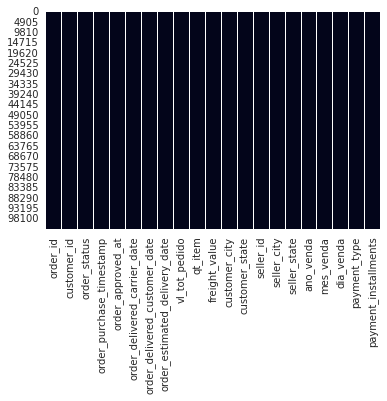

In [148]:
sns.heatmap(ds_pedidos_itens_unicos.isnull(), cbar = False);

In [149]:
ds_pedidos_itens_unicos.query("order_id == '947e9c6bfd83a06953c420ef92d3da6e'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state,ano_venda,mes_venda,dia_venda,payment_type,payment_installments


In [150]:
ds_pedidos_itens_unicos.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state,ano_venda,mes_venda,dia_venda,payment_type,payment_installments
102999,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,72.00,1.0,13.08,sao jose dos campos,SP,e24fc9fcd865784fb25705606fe3dfe7,braganca paulista,SP,2017,3,9,credit_card,3
103000,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,174.90,1.0,20.10,praia grande,SP,1f9ab4708f3056ede07124aad39a2554,tupa,SP,2018,2,6,credit_card,3
103001,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,205.99,1.0,65.02,nova vicosa,BA,d50d79cb34e38265a8649c383dcffd48,sao paulo,SP,2017,8,27,credit_card,5
103002,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,359.98,2.0,81.18,japuiba,RJ,a1043bafd471dff536d0c462352beb48,ilicinea,MG,2018,1,8,credit_card,4
103003,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03,68.50,1.0,18.36,lapa,PR,ececbfcff9804a2d6b40f589df8eef2b,franca,SP,2018,3,8,debit_card,1


In [151]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,freight_value,customer_city,customer_state,seller_id,seller_city,seller_state,ano_venda,mes_venda,dia_venda,payment_type,payment_installments
92001,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,31.8,21.0,164.37,sao paulo,SP,2709af9587499e95e803a6498a5a56e9,sao paulo,SP,2017,7,16,credit_card,2


In [152]:
ds_pedidos_itens_unicos["payment_type"] = ds_pedidos_itens_unicos["payment_type"].astype('category')
ds_pedidos_itens_unicos['payment_type_cat'] = ds_pedidos_itens_unicos['payment_type'].cat.codes

In [153]:
ds_pedidos_itens_unicos.corr()

,vl_tot_pedido,qt_item,freight_value,ano_venda,mes_venda,dia_venda,payment_installments,payment_type_cat
vl_tot_pedido,1.000000,0.158163,0.416464,-0.000302,0.000597,-0.006985,0.307677,0.003681
qt_item,0.158163,1.000000,0.451796,0.006768,0.002345,0.012109,0.080765,-0.016569
freight_value,0.416464,0.451796,1.000000,0.031827,0.004398,-0.007582,0.197522,-0.006407
ano_venda,-0.000302,0.006768,0.031827,1.000000,-0.549285,-0.042875,-0.050269,-0.004190
mes_venda,0.000597,0.002345,0.004398,-0.549285,1.000000,-0.000179,0.030753,-0.001578
dia_venda,-0.006985,0.012109,-0.007582,-0.042875,-0.000179,1.000000,0.001349,0.001265
payment_installments,0.307677,0.080765,0.197522,-0.050269,0.030753,0.001349,1.000000,0.070055
payment_type_cat,0.003681,-0.016569,-0.006407,-0.004190,-0.001578,0.001265,0.070055,1.000000


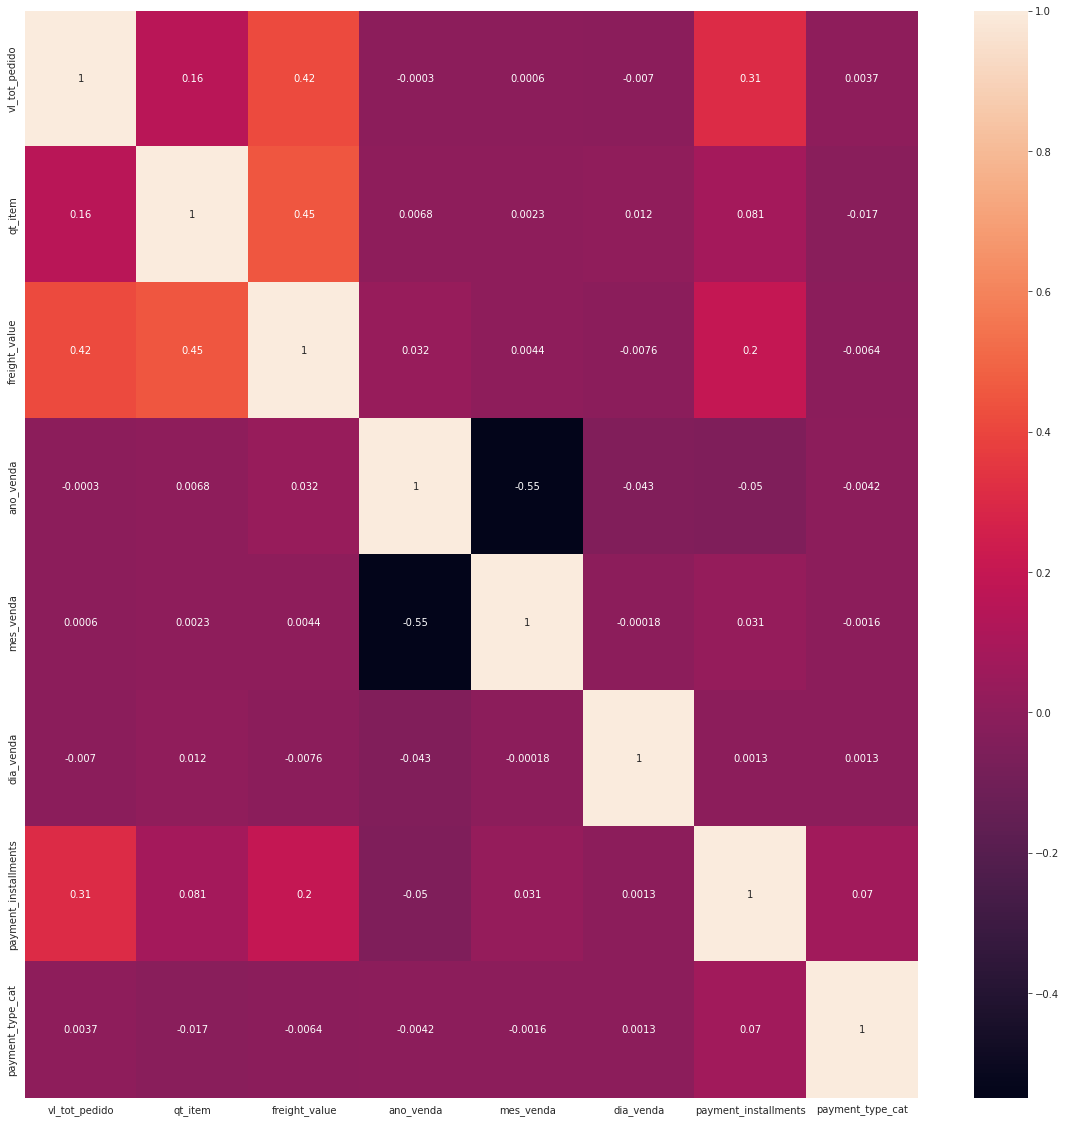

In [154]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ds_pedidos_itens_unicos.corr(), annot = True);

## As vendas estão concentradas em cartão de crédito e boleto, ultrapassando 90% das vendas.

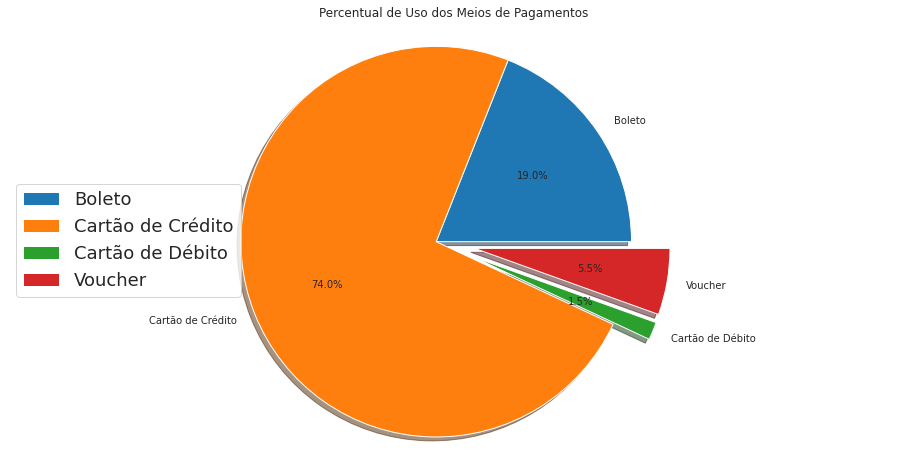

In [155]:
ds_tipo_pg_pedido = ds_pedidos_itens_unicos.groupby(['payment_type'])['order_id'].count()

labels = ['Boleto', 'Cartão de Crédito', 'Cartão de Débito', 'Voucher']

explode = (0.0, 0.0, 0.2, 0.2) 

plt.figure(figsize=(16,8))

plt.pie(ds_tipo_pg_pedido, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode)

plt.legend(labels, loc=6, fontsize=18)
plt.title('Percentual de Uso dos Meios de Pagamentos')
plt.axis('equal')

plt.show()

## Uso dos tipos de pagamento mês a mês

### De Março a Setembro é o período de maior vendas, e também, o de maior uso de cartão de crédito.

In [ ]:
ds_tipo_boleto_mes       = ds_pedidos_itens_unicos.query('payment_type == "boleto"').groupby('mes_venda')['payment_type'].count()
ds_tipo_credit_card_mes  = ds_pedidos_itens_unicos.query('payment_type == "credit_card"').groupby('mes_venda')['payment_type'].count()
ds_tipo_debit_card_mes   = ds_pedidos_itens_unicos.query('payment_type == "debit_card"').groupby('mes_venda')['payment_type'].count()
ds_tipo_voucher_mes      = ds_pedidos_itens_unicos.query('payment_type == "voucher"').groupby('mes_venda')['payment_type'].count()

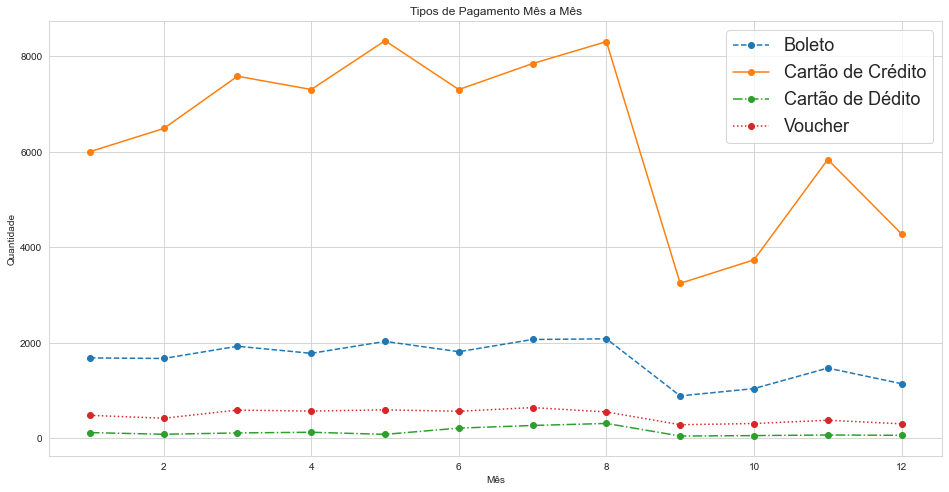

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(ds_tipo_boleto_mes.index, ds_tipo_boleto_mes.values, label = "Boleto", linestyle="--", marker='o')

plt.plot(ds_tipo_credit_card_mes.index, ds_tipo_credit_card_mes.values, label = "Cartão de Crédito", linestyle="-", marker='o')

plt.plot(ds_tipo_debit_card_mes.index, ds_tipo_debit_card_mes.values, label = "Cartão de Dédito", linestyle="-.", marker='o')
plt.plot(ds_tipo_voucher_mes.index, ds_tipo_voucher_mes.values, label = "Voucher", linestyle=":", marker='o')

plt.legend(fontsize=18)
plt.title('Tipos de Pagamento Mês a Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.show()

## Dias da Semana x Vendas x Tipos de Pagamentos

In [156]:
ds_pedidos_itens_unicos['dia_semana_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp'].apply(lambda x: x.strftime('%A'))

In [157]:
ds_dia_semana_vendas_totais = ds_pedidos_itens_unicos.groupby('dia_semana_venda')['vl_tot_pedido'].sum()

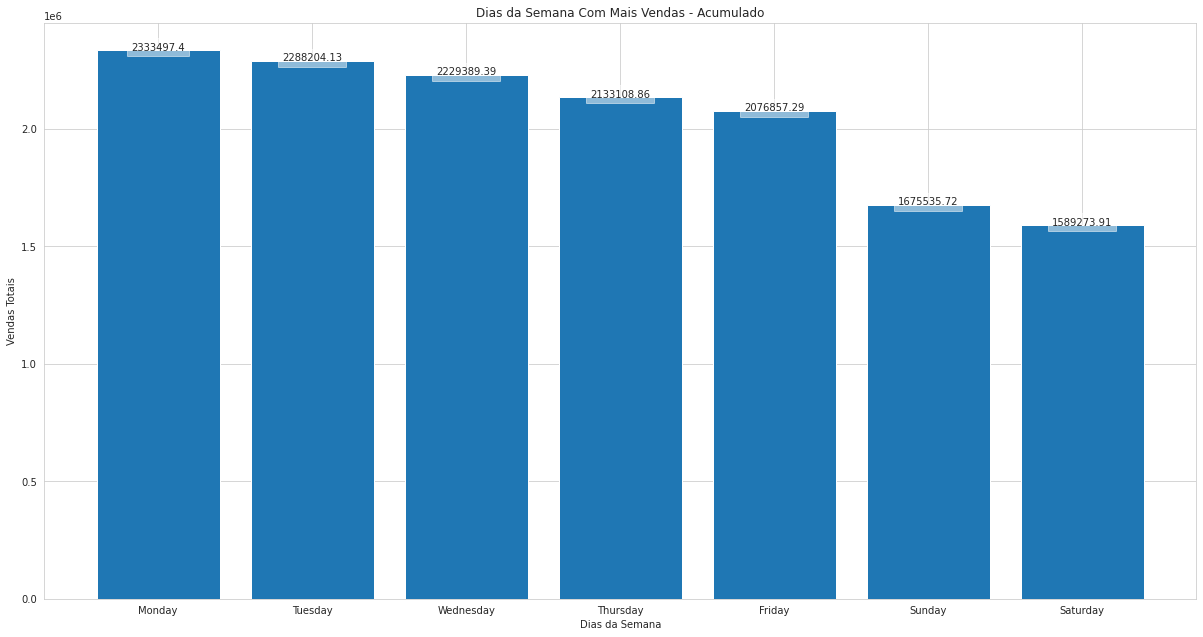

In [158]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
            bbox = dict(facecolor = 'white', alpha = .5))

ds_dia_semana_vendas_totais = ds_dia_semana_vendas_totais.sort_values(ascending=False)

fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(ds_dia_semana_vendas_totais.index, ds_dia_semana_vendas_totais.values)

addlabels(ds_dia_semana_vendas_totais.index, ds_dia_semana_vendas_totais.values)

plt.title('Dias da Semana Com Mais Vendas - Acumulado')
plt.xlabel('Dias da Semana')
plt.ylabel('Vendas Totais')
plt.show()

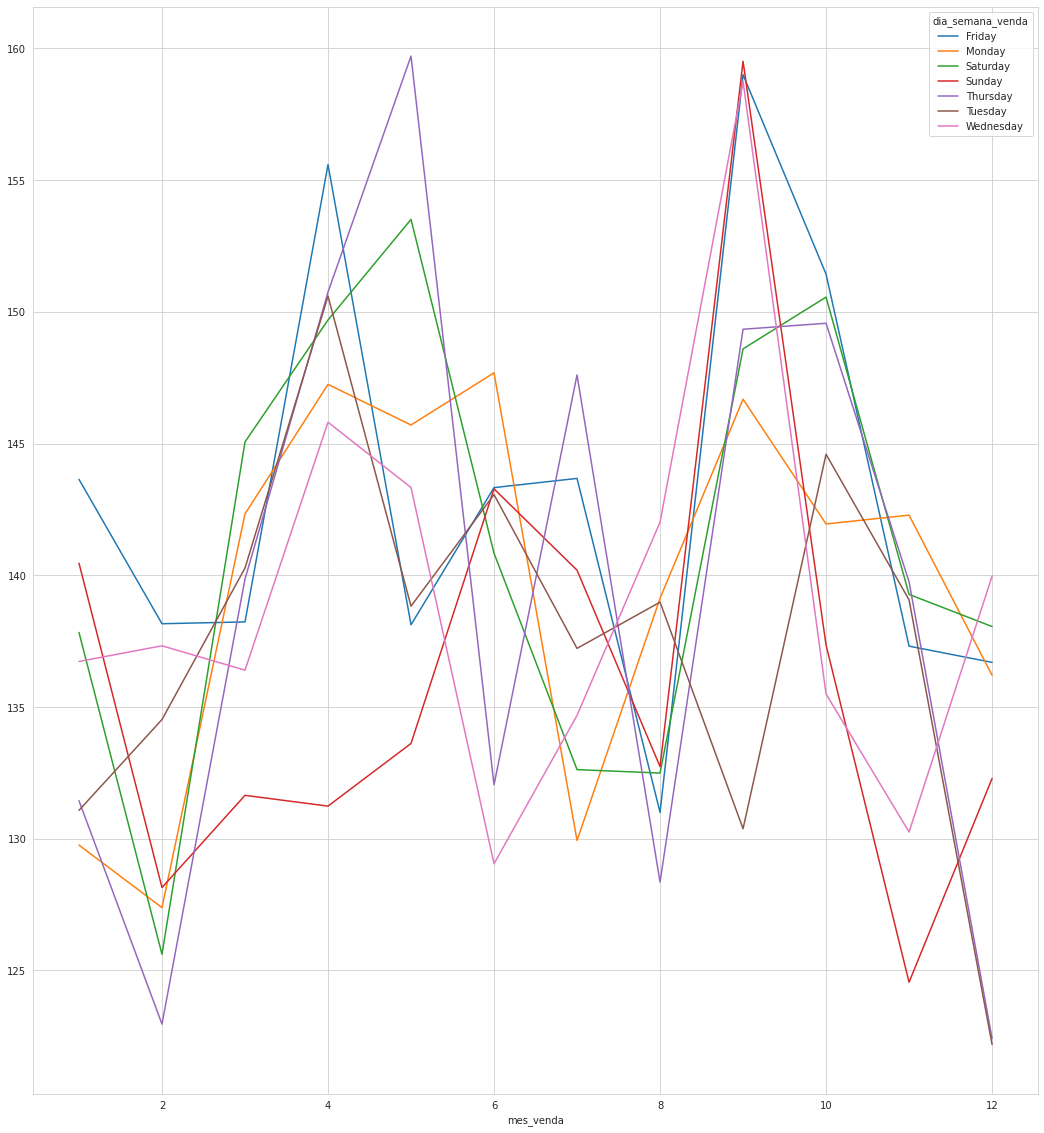

In [159]:
fig, ax = plt.subplots(figsize = (18,20))
ds_pedidos_itens_unicos.groupby(['mes_venda', 'dia_semana_venda']).mean()['vl_tot_pedido'].unstack().plot(ax = ax);

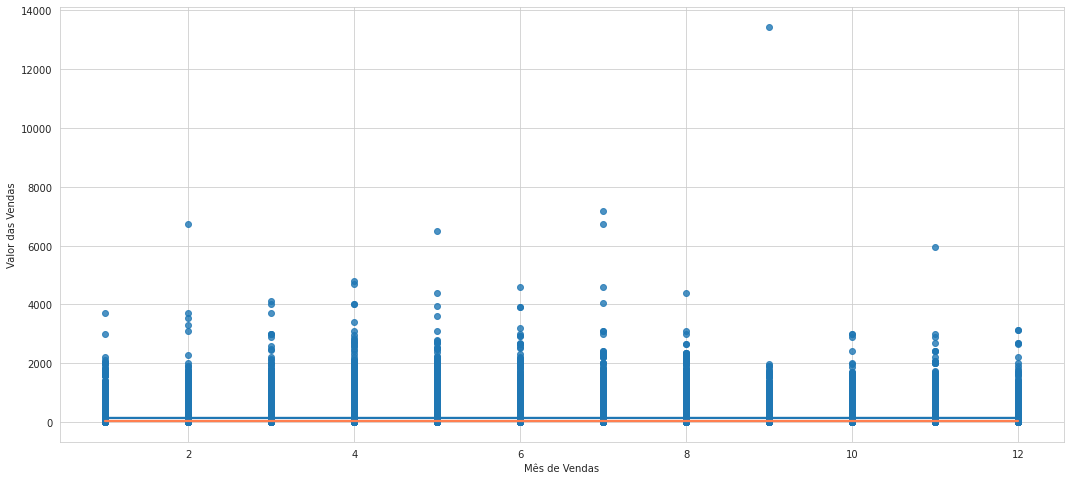

In [160]:
f, ax = plt.subplots(figsize=(18, 8))
sns.regplot(x="mes_venda", y="freight_value", data=ds_pedidos_itens_unicos, ax=ax, color="coral").set(
    xlabel='Mês de Vendas',
    ylabel='Valor das Vendas',  
)
sns.regplot(x="mes_venda", y="vl_tot_pedido", data=ds_pedidos_itens_unicos, ax=ax).set(
    xlabel='Mês de Vendas',
    ylabel='Valor das Vendas',    
)
plt.show()

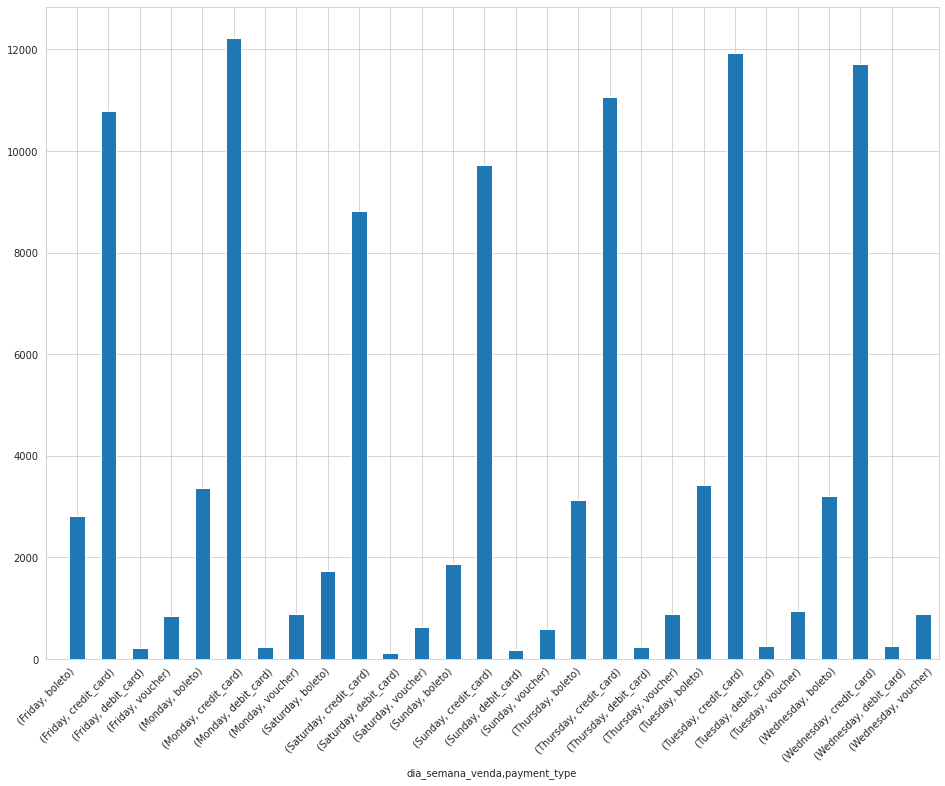

In [161]:
ds_pedidos_itens_unicos.groupby(['dia_semana_venda', 'payment_type'])['payment_type'].count().plot(kind='bar', rot = 45, position = -1.5, figsize = (16, 12), layout=(3,4), align='center');

# Análise para Previsão de Vendas

In [166]:
# id_vendedor = recebe id do vendedor para filtrar a previsão, caso contrário, envie o valor zero 0
# base = recebe o conteúdo a ser previsto, contendo data e valores de vendas como predecessoras.
# feriados = recebe um dataframe com datas de feriados (ds, holiday), caso contrário, envie o valor zero 0
# periodo = recebe uma quantidade de dias futuro para previsão das vendas

def previsao_vendas(id_vendedor, base, feriados, periodo):
    if id_vendedor != 0:
        if base[base['seller_id']] == id_vendedor:
            base = base[base['seller_id'] == id_vendedor]
            
    base = base[['order_purchase_timestamp', 'vl_tot_pedido']].rename(columns = {'order_purchase_timestamp': 'ds', 'vl_tot_pedido': 'y'})
    base = base.sort_values(by = 'ds')
    
    if feriados == 0:
        model = Prophet()
    else:
        model = Prophet(holidays = feriados)
    
    model.fit(base)
    
    futuro = model.make_future_dataframe(periods = periodo)
    previsao = model.predict(futuro)
    
    figure_01 = model.plot(previsao, xlabel = 'Data', ylabel = 'Vendas')
    figure_02 = model.plot_components(previsao)
    
    return base, previsao;
        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


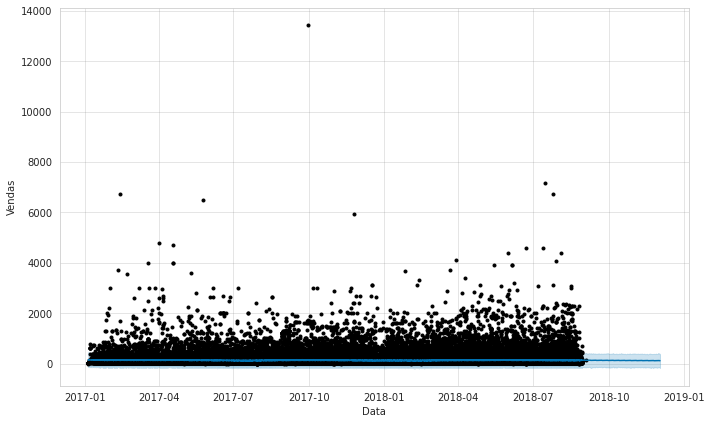

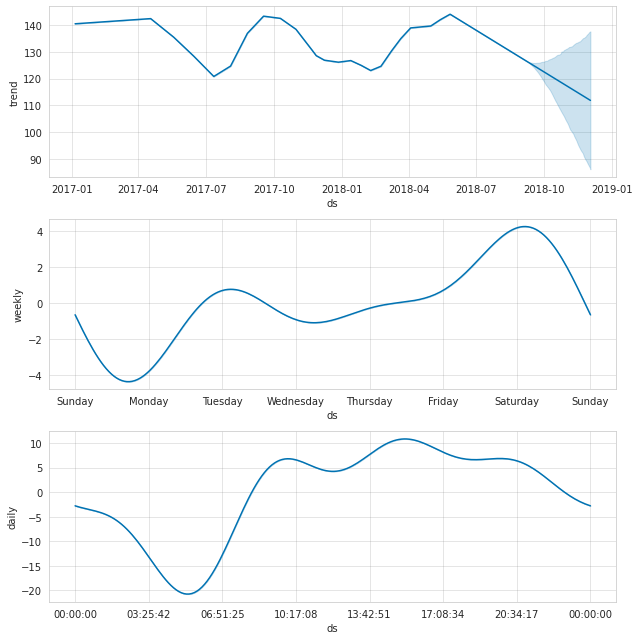

In [185]:
# Previsão de 90 dias a frente
# Dados de predecessores completos são de 2017 e 2018
base_original, base_previsao = previsao_vendas(0, ds_pedidos_itens_unicos.query('ano_venda == 2017 or ano_venda == 2018'), 0, 90)

## Previsão de Vendas para os Próximos 90 dias

In [186]:
base_original.shape, base_previsao.shape

((102673, 2), (96522, 19))

In [187]:
base_previsao.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
96517,2018-11-28 09:06:57,112.549354,-166.213786,380.271463,88.493865,136.528011,4.313550,4.313550,4.313550,5.353145,5.353145,5.353145,-1.039595,-1.039595,-1.039595,0.0,0.0,0.0,116.862904
96518,2018-11-29 09:06:57,112.379785,-150.685337,385.394894,87.977738,136.797504,5.377571,5.377571,5.377571,5.353145,5.353145,5.353145,0.024427,0.024427,0.024427,0.0,0.0,0.0,117.757356
96519,2018-11-30 09:06:57,112.210216,-150.666568,421.639809,87.454590,137.191812,7.353750,7.353750,7.353750,5.353145,5.353145,5.353145,2.000605,2.000605,2.000605,0.0,0.0,0.0,119.563966
96520,2018-12-01 09:06:57,112.040647,-134.256020,398.864467,86.920311,137.478775,9.099245,9.099245,9.099245,5.353145,5.353145,5.353145,3.746100,3.746100,3.746100,0.0,0.0,0.0,121.139892
96521,2018-12-02 09:06:57,111.871078,-171.325927,384.260458,86.203756,137.600467,1.933063,1.933063,1.933063,5.353145,5.353145,5.353145,-3.420081,-3.420081,-3.420081,0.0,0.0,0.0,113.804142


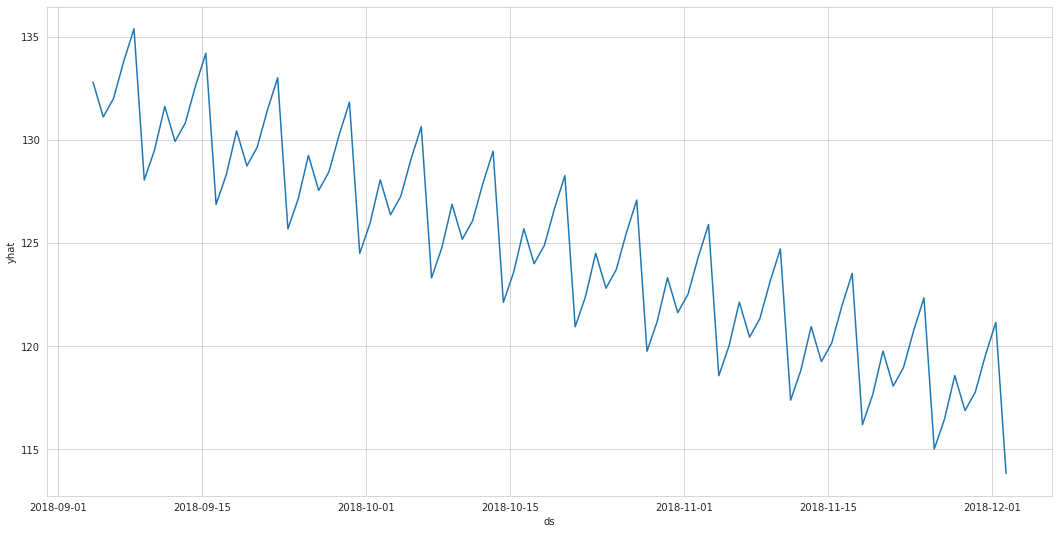

In [188]:
#ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2018.groupby('dia_venda')['vl_tot_pedido'].mean()
#ds_dia_vendas_total.reset_index()
base_previsao_futuro = base_previsao.tail(90)
plt.figure(figsize=(18,9))
sns.lineplot(data=base_previsao_futuro, x="ds", y="yhat")

### Tranformando atributos textuais em categóricos

In [ ]:
#ds_pedidos_itens_unicos["order_status"] = ds_pedidos_itens_unicos["order_status"].astype('category')
#ds_pedidos_itens_unicos['order_status_cat'] = ds_pedidos_itens_unicos['order_status'].cat.codes

In [ ]:
ds_pedidos_itens_unicos.query("vl_tot_pedido == 'NaT'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,...,seller_id,seller_city,seller_state,ano_venda,mes_venda,payment_type,payment_installments,payment_type_cat,dia_semana_venda,dia_venda


<AxesSubplot:>

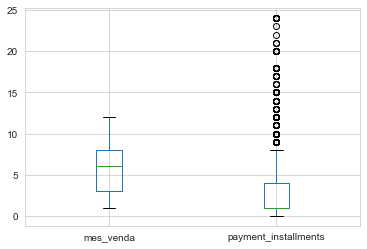

In [ ]:
ds_pedidos_itens_unicos[['mes_venda', 'payment_installments']].boxplot()

<AxesSubplot:>

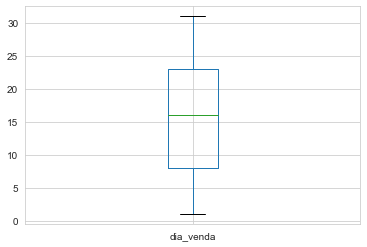

In [ ]:
ds_pedidos_itens_unicos[['dia_venda']].boxplot()

<AxesSubplot:>

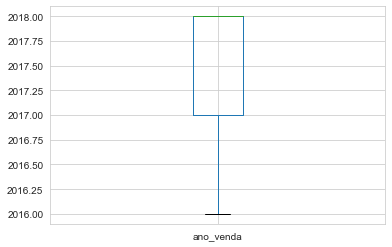

In [ ]:
ds_pedidos_itens_unicos[['ano_venda']].boxplot()

<AxesSubplot:>

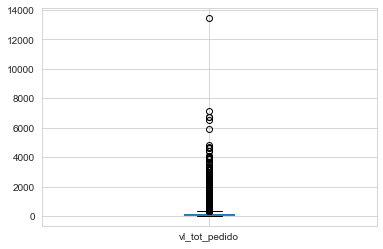

In [ ]:
ds_pedidos_itens_unicos[['vl_tot_pedido']].boxplot()

<AxesSubplot:>

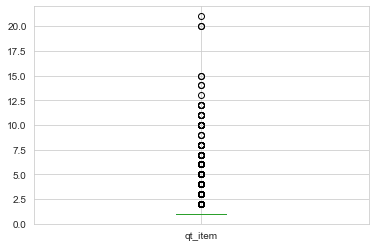

In [ ]:
ds_pedidos_itens_unicos[['qt_item']].boxplot()

In [ ]:
ds_pedidos_itens_unicos.describe()

In [ ]:
ds_pedidos_itens_unicos[ds_pedidos_itens_unicos.isnull()]

In [ ]:
ds_pedidos_itens_unicos.isnull().sum()

In [ ]:
ds_pedidos_itens_unicos['customer_id'].value_counts()

In [ ]:
ds_pedidos_itens_unicos.query('customer_id == "270c23a11d024a44c896d1894b261a83"')

In [ ]:
ds_dia_semana_tipo_pg.values

In [ ]:
ds_reviews.head()

In [ ]:
ds_categorias.head()

In [ ]:
#ds_produtos_pedidos_dummies = pd.get_dummies(ds_produtos_pedidos, columns=['product_category_name'])
#ds_produtos_pedidos_dummies.head()

In [ ]:
ds_produtos.head()

In [ ]:
#ds_pedidos_itens_unicos["seller_state"] = ds_pedidos_itens_unicos["seller_state"].astype('category')
#ds_pedidos_itens_unicos['seller_state_cat'] = ds_pedidos_itens_unicos['seller_state'].cat.codes

In [ ]:
#ds_pedidos_itens_unicos["customer_state"] = ds_pedidos_itens_unicos["customer_state"].astype('category')
#ds_pedidos_itens_unicos['customer_state_cat'] = ds_pedidos_itens_unicos['customer_state'].cat.codes

In [ ]:
ds_pedidos_itens_unicos.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,vl_tot_pedido,qt_item,...,seller_id,seller_city,seller_state,ano_venda,mes_venda,payment_type,payment_installments,payment_type_cat,dia_semana_venda,dia_venda
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,...,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,2017,10,credit_card,1,1,Monday,2
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,...,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,2017,10,voucher,1,3,Monday,2
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,1.0,...,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,2017,10,voucher,1,3,Monday,2
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,1.0,...,289cdb325fb7e7f891c38608bf9e0962,belo horizonte,SP,2018,7,boleto,1,0,Tuesday,24
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,1.0,...,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,2018,8,credit_card,3,1,Wednesday,8
